# Summary of Code Base
This notebook represents an attempt at creating a models to forecast wait times in the interconnection as well as better understanding the queue across various ISOs, including CAISO, ERCOT, PJM, and ISO NE. Most of the data extracted came from the Lawrence Berkeley National Lab, which can be found here: https://emp.lbl.gov/queues 
This code base is devided into different sections 
- Data preprocessing  
This section aims at reading the various data sets and preparing helper functions that will assist
- Helper Function preparation



# Data Preprocessing

In [43]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from pandas import Timestamp
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

In [44]:
pd.reset_option('all')

In [45]:
excel_file = pd.ExcelFile("queues_2023_clean_data.xlsx")
interconnection_data = excel_file.parse("data")


In [46]:
interconnection_data.drop(["q_year", "prop_year"], axis=1, inplace=True)

#### Issues with the dataset

A lot of projects, even though they were withdrawn or completed, they do not have the date in which they occured, in fact none of the PJM Projects have completion dates. 

Some projects, especially in ISO New England, do not specify the capacity and simply leave it as 0.

A lot of unkown with iso-ne project types.

### Official CAISO report

The original data set has some issues, so we'll combine it with data sets directly from different isos, particularly from iso_ne and caiso reports. For PJM, there is almost no data at all, so we'll extract data from a interconnection website online.


In [ ]:
added_caiso_path = "External Data\CAISO_REPORT.xlsx"
added_iso_ne_path = "External Data\ISO_NE_REPORT.xlsx"
caiso_data = pd.ExcelFile(added_caiso_path)
iso_ne_data = pd.ExcelFile(added_iso_ne_path)


In [ ]:
completed_projects = caiso_data.parse("Completed Generation Projects", skiprows=3)
withdrawn_projects = caiso_data.parse("Withdrawn Generation Projects", skiprows=3)
queue_projects = caiso_data.parse("Grid GenerationQueue", skiprows=3)


In [ ]:

# Define the column mappings to map back to original LBNL format
completed_projects_mapping = {
    'Project Name': 'project_name', 'Queue Position': 'q_id', 'Queue Date': 'q_date',
    'Application Status': 'q_status', 'Proposed\nOn-line Date\n(as filed with IR)': 'prop_date',
    'Actual\nOn-line Date': 'on_date', 'Interconnection Agreement \nStatus': 'IA_status_raw',
    'County': 'county_1', 'State': 'state', 'Utility': 'utility',
    'MW-1': 'mw1', 'MW-2': 'mw2', 'MW-3': 'mw3', 'Type-1': 'type1', 'Type-2': 'type2', 'Type-3': 'type3'
}

withdrawn_projects_mapping = {
    'Project Name - Confidential': 'project_name', 'Queue Position': 'q_id', 'Queue Date': 'q_date',
    'Application Status': 'q_status', 'Withdrawn Date': 'wd_date', 'Proposed\nOn-line Date\n(as filed with IR)': 'prop_date',
    'Interconnection Agreement \nStatus': 'IA_status_raw',
    'County': 'county_1', 'State': 'state', 'Utility': 'utility',
    'MW-1': 'mw1', 'MW-2': 'mw2', 'MW-3': 'mw3', 'Type-1': 'type1', 'Type-2': 'type2', 'Type-3': 'type3'
}

queue_projects_mapping = {
    'Project Name': 'project_name', 'Queue Position': 'q_id', 'Queue Date': 'q_date',
    'Application Status': 'q_status', 'Proposed\nOn-line Date\n(as filed with IR)': 'prop_date',
    'Interconnection Agreement \nStatus': 'IA_status_raw',
    'County': 'county_1', 'State': 'state', 'Utility': 'utility',
    'MW-1': 'mw1', 'MW-2': 'mw2', 'MW-3': 'mw3', 'Type-1': 'type1', 'Type-2': 'type2', 'Type-3': 'type3'
}

# Define the common columns based on sorted_caiso
common_columns = [
    'q_id', 'q_status', 'q_date', 'ia_date', 'wd_date', 'on_date', "county_1", #'entity',
    # 'project_name', 'developer', 'utility', 'county_1', 'county_2', 'county_3',
    #'state', 'region', 'service', 'poi_name', 'prop_date', 'IA_status_raw',
    #'IA_status_clean',
    'type_clean', 'type1', 'type2', 'type3', 'mw1', 'mw2', 'mw3'
]
# Rename columns and keep only necessary ones


In [ ]:
completed_projects = completed_projects.rename(columns=completed_projects_mapping).loc[:, list(completed_projects_mapping.values())]
withdrawn_projects = withdrawn_projects.rename(columns=withdrawn_projects_mapping).loc[:, list(withdrawn_projects_mapping.values())]
queue_projects = queue_projects.rename(columns=queue_projects_mapping).loc[:, list(queue_projects_mapping.values())]


In [ ]:
common_column_dict = {col: index for index, col in enumerate(common_columns)}

# Ensure all DataFrames have the same columns, filling missing ones with NaN
for i, df in enumerate([completed_projects, withdrawn_projects, queue_projects]):
    for col in common_columns:
        if col not in df.columns:
            df[col] = pd.NA  # Fill missing columns with NaN

    # Reorder and trim to common columns
    df = df[[col for col in common_column_dict]]

    # Reassign to original variable
    if i == 0:
        completed_projects = df
    elif i == 1:
        withdrawn_projects = df
    else:
        queue_projects = df


In [ ]:
new_caiso = pd.concat([completed_projects, withdrawn_projects, queue_projects], ignore_index=True)


The caiso report does not include active projects with ids that start with caiso_c15, which all started on 2023, making for about 500 projects.

#### Official ISO NE Report

In [94]:
iso_ne_queue = iso_ne_data.parse("Queue", skiprows=4)
iso_ne_queue
# new_iso_ne = iso_ne_queue[common_columns]
# new_iso_ne
# mapping = {" # Position": "q_id", "Requested": "q_date", "Application Status": "q_status",}


Position                 Updated Type            Requested  \
0         1601 2025-01-17 13:30:53.720    G  2025-01-14 00:00:00   
1         1600 2025-03-14 09:53:49.883    G  2024-12-12 00:00:00   
2         1599 2025-01-10 16:54:51.729    G  2024-12-12 00:00:00   
3         1598 2025-01-10 16:51:05.488    G  2024-12-12 00:00:00   
4         1597 2025-01-10 16:41:18.390    G  2024-12-12 00:00:00   
...        ...                     ...  ...                  ...   
1746         5                     NaT    G  1997-05-09 00:00:00   
1747         4                     NaT    G  1997-04-10 00:00:00   
1748         3                     NaT    G  1997-02-13 00:00:00   
1749         2                     NaT    G  1996-11-08 00:00:00   
1750         1                     NaT    G                35223   

                          Alternative Name Unit Fuel Type   Net MW  Summer MW  \
0                                     BESS   OT       BAT     4.99       4.99   
1          Chazy Lake BESS (NYISO-C24-308)   OT       BAT    50.00      50.00   
2            Dover NY BESS (NYISO-C24-316)   OT       BAT  1000.00    1000.00   
3     Zenobe Rotterdam LLC (NYISO-C24-191)   OT       BAT   100.00     100.00   
4        New Scotland BESS (NYISO-C24-045)   OT       BAT  1350.00    1350.00   
...                                    ...  ...       ...      ...        ...   
1746                            Brayton Pt  NaN       NaN      NaN        NaN   
1747             EMI Dighton Power Project   CC        NG      NaN        NaN   
1748            Androscoggin Energy Center   CC    DFO NG      NaN        NaN   
1749                          EMI-Tiverton   CC        NG      NaN        NaN   
1750                       Millennium+K117   CC    DFO NG      NaN        NaN   

      Winter MW  ...    I39 TO Report  Dev  Zone   FS  SIS   OS  FAC   IA  \
0          4.99  ...  False       NaN  NaN  BOST  NaN  NaN  NaN  NaN  NaN   
1         50.00  ...  False       NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
2       1000.00  ...  False       NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
3        100.00  ...  False       NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
4       1350.00  ...  False       NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
...         ...  ...    ...       ...  ...   ...  ...  ...  ...  ...  ...   
1746        NaN  ...   True     NGRID  NaN    RI  NaN  NaN  NaN  NaN  NaN   
1747        NaN  ...   True     NGRID  NaN  SEMA  NaN  NaN  NaN  NaN  NaN   
1748        NaN  ...   True       CMP  NaN    ME  NaN  NaN  NaN  NaN  NaN   
1749        NaN  ...   True     NGRID  NaN  SEMA  NaN  NaN  NaN  NaN  NaN   
1750        NaN  ...   True     NGRID  NaN   WMA  NaN  NaN  NaN  NaN  NaN   

     Project Status  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
1746            NaN  
1747            NaN  
1748            NaN  
1749            NaN  
1750            NaN  

[1751 rows x 28 columns]

The new ISO Ne report does not seem to be particularly useful, so we have not incorporated it fully yet

### Webscrapping
PJM does not have any dates for any of the projects, and any official reports from the PJM ISO could not be found. There is a website https://www.interconnection.fyi that collects data on the US interconnection queue and project information. Using webscrapping we can extract information from that website (please evaluate the ethics of doing this froma an academic research perspective)

In [ ]:


import requests
from bs4 import BeautifulSoup

def find_info(iso,q_id,info_type):
    """Finds the status of a project given its ISO and queue ID, can be withdrawn active.
    acceptable info_type values are:
    'Power Market', 'Interconnection', 'Queue', 'Status', "Proposed Completion Date", 'Withdrawn Date'"""
    try:
        url = f"https://www.interconnection.fyi/project/{iso}-{q_id}"
        response = requests.get(url)
        soupt = BeautifulSoup(response.content, "html.parser")
        table = soupt.find("table")
        rows = table.find_all("tr")
        for target_row in rows:
            cells = target_row.find_all("td")
            if info_type in cells[0].get_text(strip=True):
                result = cells[1].get_text(strip=True).lower()
                    # If the withdraw date is unknown, return the proposed date
                return result
        if info_type == "Withdrawn Date": # if the withdraw date is requested, return the proposed date if not found
            return find_info(iso, q_id, "Proposed Completion Date")
        return "unknown"
    except Exception as e:
        return "unknown"

# Uncomment the following lines to fetch and process PJM data, or use the pre-sorted CSV file "pjm_sorted.csv".
# for i, row in pjm.iterrows():
#     status = row["q_status"]
#     q_id = row["q_id"].lower()
#     q_id = q_id.replace("_", "-")
#     if status == "operational":
#         on_date = find_info("pjm", q_id, "Completion Date")
#         if on_date == "unknown":
#             continue
#         pjm.at[i, "on_date"] = datetime.strptime(on_date, "%B %d, %Y")
#     elif status == "withdrawn":
#         wd_date = find_info("pjm", q_id, "Withdrawn Date")
#         if wd_date == "unknown":
#             continue
#         pjm.at[i, "wd_date"] = datetime.strptime(wd_date, "%B %d, %Y")
#     if i%50 == 0:
#         print(f"Processed {i} rows of PJM data...")
# pjm.to_csv("pjm_sorted.csv", index=False)


### Helper Functions

We have here a few helper functions that we will need to perform all our calculations 

Note: The LBNL report and the caiso report have somewhat different labels for the type of energy source for the same project, for instance the project with q_id: 1A is referred to as gas in the LBNL report but it's referred to as combined cycle in the CAISO report

In [142]:
renewable_types = {
    'Hydro',
    'Photovoltaic',
    'Solar Thermal',
    'Offshore Wind',
    "Solar",
    'Wind',
    'Wind Turbine',
    'Biofuel',
    'Biomass',
    'Nuclear'
    'Geothermal',
    'Pumped Storage'
}

non_renewable_types = {
    'Gas',
    'Oil',
    'Gas Turbine',
    'Coal',
    "Methane",
    "Diesel",
    'Combustion Turbine',
    'Steam Turbine',
    'Co-Gen',
    'Cogeneration',
    'Combined Cycle',
    'Reciprocating Engine',
    'Other'
}

storage_types = {
    'Battery',
    'Storage',
    "Pumped Storage",
    'Other Storage'
}

def average_wait_times(iso):
    """Calculates average and standard deviation of wait times per county."""
    completed = iso[iso["on_date"].notna()].copy()
    completed["time_difference"] = calculate_difference(completed, unit="years")

    stats = completed.groupby("county_1")["time_difference"].agg(
        avg_wait_time="mean",
        std_wait_time="std",
        project_count="count",
    ).reset_index()

    return stats


def convert_to_datetime(iso):
    """Converts date columns to datetime format."""
    date_columns = ["q_date", #"ia_date",
                    "wd_date", "on_date", #"prop_date"
                    ]
    for col in date_columns:
        iso[col] = pd.to_datetime(
            iso[col], errors="coerce"
        )

def renewable_split(data):
    """Changes a column into categorical variables
    1 for renewable, 2 for non-renewable, 3 for storage, 0 for uncategorized."""
    new_df = data.copy()
    for column in ["type1","type2","type3"]:
        categorical = []
        for _, row in data.iterrows():
            item = row[column]
            if item in renewable_types:
                categorical.append(1)
            elif item in non_renewable_types:
                categorical.append(2)
            elif item in storage_types:
                categorical.append(3)
            else:
                categorical.append(0)
        new_df[column] = categorical
    return new_df

def full_categorical_change(iso):
    """Converts all categorical columns to numerical values using LabelEncoder."""
    categorical_iso = iso.copy()
    encoder = LabelEncoder()

    all_categories = pd.concat([categorical_iso['type1'], categorical_iso['type2'], categorical_iso['type3'],categorical_iso["county_1"]]).unique()
    encoder.fit(all_categories)

    categorical_iso['type1'] = encoder.transform(categorical_iso['type1'])
    categorical_iso['type2'] = encoder.transform(categorical_iso['type2'])
    categorical_iso['type3'] = encoder.transform(categorical_iso['type3'])
    categorical_iso['county_1'] = encoder.transform(categorical_iso['county_1'])

    return categorical_iso
def categorical_change(iso):
    """Converts a specific categorical column to numerical values using LabelEncoder."""
    new_df = iso.copy()
    categorical_columns = ["type1", "type2", "type3"]
    categories = {}
    for col in categorical_columns:
        for index, item in enumerate(new_df[col].unique()):
            if item not in categories:
                if  pd.isna(item):
                    categories[item] = len(categories) + 1  # Assign NaN a unique code
                else:
                    categories[item] = index + 1
        new_df[col] = new_df[col].map(categories)
    return new_df, categories

def invert_dictionary(categories):
    """Inverts a dictionary to map numerical values back to their original categorical values."""
    inverted = {v: k for k, v in categories.items()}
    return inverted
        # categories[item] = index
# def full_categorical_change(iso):
#     """Converts all categorical columns to numerical values. Missing values get largest code."""
#     new_df = iso.copy()

#     categorical_cols = ['type1', 'type2', 'type3', 'county_1']

#     # Step 1 — fill NaN with "Missing"
#     for col in categorical_cols:
#         new_df[col] = new_df[col].fillna("Missing")

#     # Step 2 — force the LabelEncoder to learn "Missing" last
#     encoder = LabelEncoder()

#     # Force categories in a known order
#     all_categories = pd.concat([new_df[col] for col in categorical_cols]).unique().tolist()

#     # Move "Missing" to last position
#     all_categories = [cat for cat in all_categories if cat != "Missing"]
#     all_categories.sort()  # Sort other categories if desired
#     all_categories.append("Missing")

#     encoder.classes_ = np.array(all_categories)

#     # Step 3 — Now transform each column using this encoder
#     for col in categorical_cols:
#         new_df[col] = encoder.transform(new_df[col])

#     return new_df



def select_iso(data, *isos):
    """Selects specific ISOs from the LBNL Data set."""
    result = []
    for iso in isos:
        result.append(data[data["entity"] == iso])
    result = tuple(result)
    return result


def sort_iso(*isos):
    """Sort ISO by the date they entred the queue"""
    result = []
    for iso in isos:
        sorted_iso = iso.sort_values(by="q_date", ascending=True)
        result.append(sorted_iso)
    result = tuple(result)
    return result

def order_on_date(*isos):
    """Sorts the ISOs by the date they were completed."""
    result = []
    for iso in isos:
        on_iso =  iso[iso["on_date"].notna()]
        sorted_on_iso = on_iso.sort_values(by="on_date", ascending = True)
        result.append(sorted_on_iso)
    return tuple(result)

def calculate_difference(df, unit="years",withdrawn = False):
    """For projects that have been deployed, calculates
    the time difference between the start date and end date."""

    time_difference = []

    for index, row in df.iterrows():
        delta_days = (row["on_date"] - row["q_date"]).days
        if withdrawn and row["q_status"] == "WITHDRAWN":
            delta_days = (row["wd_date"] - row["q_date"]).days
        if unit == "years":
            time_difference.append(delta_days / 365.25)
        elif unit == "months":
            time_difference.append(delta_days / 30.44)
        elif unit == "days":
            time_difference.append(float(delta_days))
    return time_difference



def exited_projects(iso):
    """Returns a list of tuples with project properties for projects that have exited the queue."""
    completed_projects = iso[iso["on_date"].notna() | iso["wd_date"].notna()] # projects that have been completed or withdrawn
    project_properties = completed_projects[["on_date","wd_date","type1","type2","type3","mw1","mw2","mw3"]] # columns we want to keep
    exit_dates = []
    for index, rows in completed_projects.iterrows():
        if pd.isna(rows["on_date"]):
            exit_dates.append(rows["wd_date"])
        else:
            exit_dates.append(rows["on_date"])
    project_properties["exit_date"]=exit_dates
    project_properties.drop(["on_date", "wd_date"], axis=1, inplace=True)
    project_properties = project_properties.fillna(0)
    # full_categorical_change(project_properties)
    # for i in ["type1","type2","type3"]:
    #     categorical_change(project_properties,i)
    project_properties = project_properties.sort_values(by = "exit_date")
    list_of_tuples = list(project_properties.itertuples(index=False, name=None))
    return list_of_tuples

# Define color mapping
def get_project_color(project_type):
    """ Colors the projects based on their type.
    Returns 'green' for renewable, 'red' for non-renewable, 'blue' for storage, and 'gray' for uncategorized."""
    if project_type in renewable_types:
        return 'green'
    elif project_type in non_renewable_types:
        return 'red'
    elif project_type in storage_types:
        return 'blue'
    else:
        return 'gray'  # if we can't find the type, we can leave it as gray

def queue_length(iso, initial_queue=0):
    """We can count the number of projects  that are currently in queue, and subtract
    as projects exit the queue by either withdrawing or completing"""
    queues = np.zeros(iso.shape[0])
    queues[0] = initial_queue

    completion_dates = sorted(iso[iso["on_date"].notna()]["on_date"].tolist())
    withdraw_dates = sorted(iso[iso["wd_date"].notna()]["wd_date"].tolist())
    # print(f"Total Completed Projects: {len(completion_dates)}")
    # print(f"Total Withdrawn Projects: {len(withdraw_dates)}")
    first_completion_date = (
        completion_dates[0] if completion_dates else Timestamp("2099-12-12")
    )
    first_withdraw_date = (
        withdraw_dates[0] if withdraw_dates else Timestamp("2099-12-12")
    )

    for i, (_, row) in enumerate(iso.iterrows()):
        current_time = row["q_date"]

        if i > 0:
            queues[i] = queues[i - 1]

        queues[i] += 1

        while (
            first_completion_date <= current_time or first_withdraw_date <= current_time
        ):
            if first_completion_date <= first_withdraw_date:
                queues[i] -= 1
                completion_dates.pop(0)
                first_completion_date = (
                    completion_dates[0] if completion_dates else Timestamp("2099-12-12")
                )
            else:
                queues[i] -= 1
                withdraw_dates.pop(0)
                first_withdraw_date = (
                    withdraw_dates[0] if withdraw_dates else Timestamp("2099-12-12")
                )

        queues[i] = max(queues[i], 0)

    return queues

In [ ]:
convert_to_datetime(interconnection_data)

caiso, ercot, pjm, iso_ne = select_iso(
    interconnection_data, "CAISO", "ERCOT", "PJM", "ISO-NE"
)
sorted_caiso, sorted_ercot, sorted_pjm, sorted_iso_ne = sort_iso(
    caiso, ercot, pjm, iso_ne
)

sorted_pjm = pd.read_csv("pjm_sorted.csv")
convert_to_datetime(sorted_pjm)
full_categorical_change(iso_ne)
# Display results
convert_to_datetime(new_caiso)
new_caiso = sort_iso(new_caiso)[0]
new_caiso["q_id"] = new_caiso["q_id"].astype(str)
new_caiso.to_csv("External Data\Combined_Caiso.csv", index=False)

# print(sorted_pjm["type1"].unique())
# sorted_pjm["on_date"] = pd.to_datetime(sorted_pjm["on_date"], errors="coerce")
sorted_on_caiso, sorted_on_ercot, sorted_on_pjm, sorted_on_iso_ne = order_on_date(
    caiso, ercot, pjm, iso_ne
)


In [58]:
# # for index, row in new_caiso.iterrows():
# #     new_id = str(row["q_id"])
# #     if new_id not in sorted_caiso["q_id"].values:
# #         print(f"ID {new_id} not found in old data.")

# compound = []
# for index, row in sorted_caiso.iterrows():
#     old_id = str(row["q_id"])
#     if old_id not in new_caiso["q_id"].values:
#         compound.append(old_id)
#         # print(f"ID {old_id} not found in new data.")
# print(len(compound), "IDs not found in new data.")

544 IDs not found in new data.


# Plotting and Data Visualization

In [78]:
new_caiso["type_clean"] = new_caiso["type1"]
queue = queue_length(new_caiso, initial_queue=0)
new_caiso["queue"] = queue
dates = new_caiso["q_date"]
completed_iso = new_caiso[new_caiso["on_date"].notna()]
completed_dates = completed_iso["q_date"]
time_difference = calculate_difference(completed_iso)




completed_iso["color"] = completed_iso["type_clean"].apply(get_project_color)

completed_iso["color"]

0        red
1        red
2        red
3        red
4        red
       ...  
219     blue
223    green
224    green
225      red
226      red
Name: color, Length: 214, dtype: object

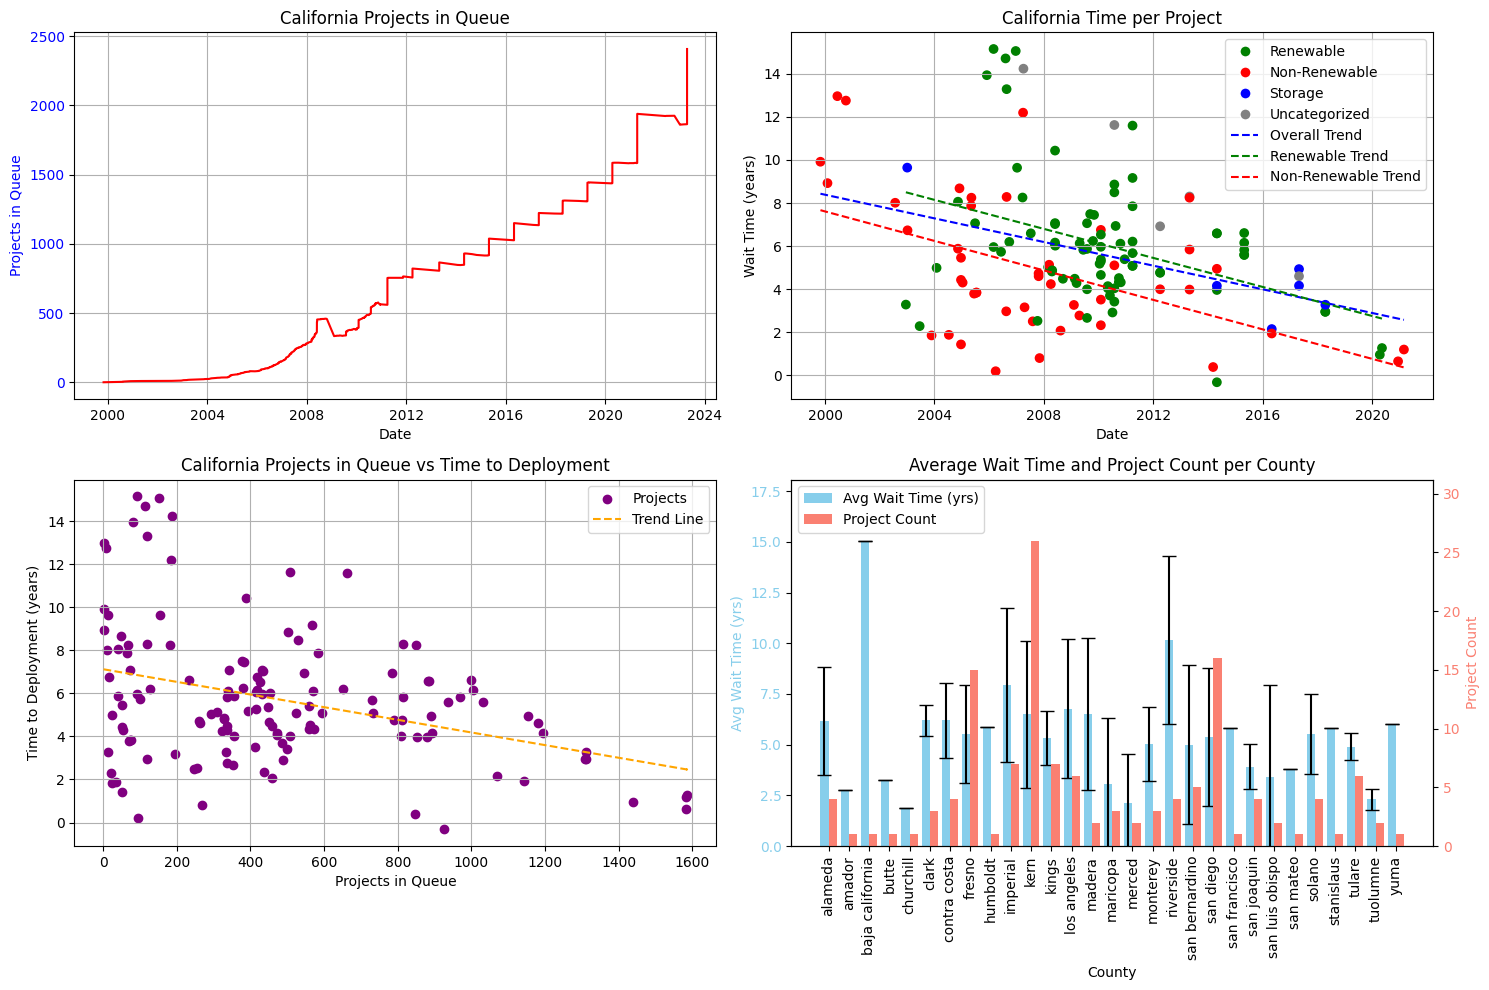

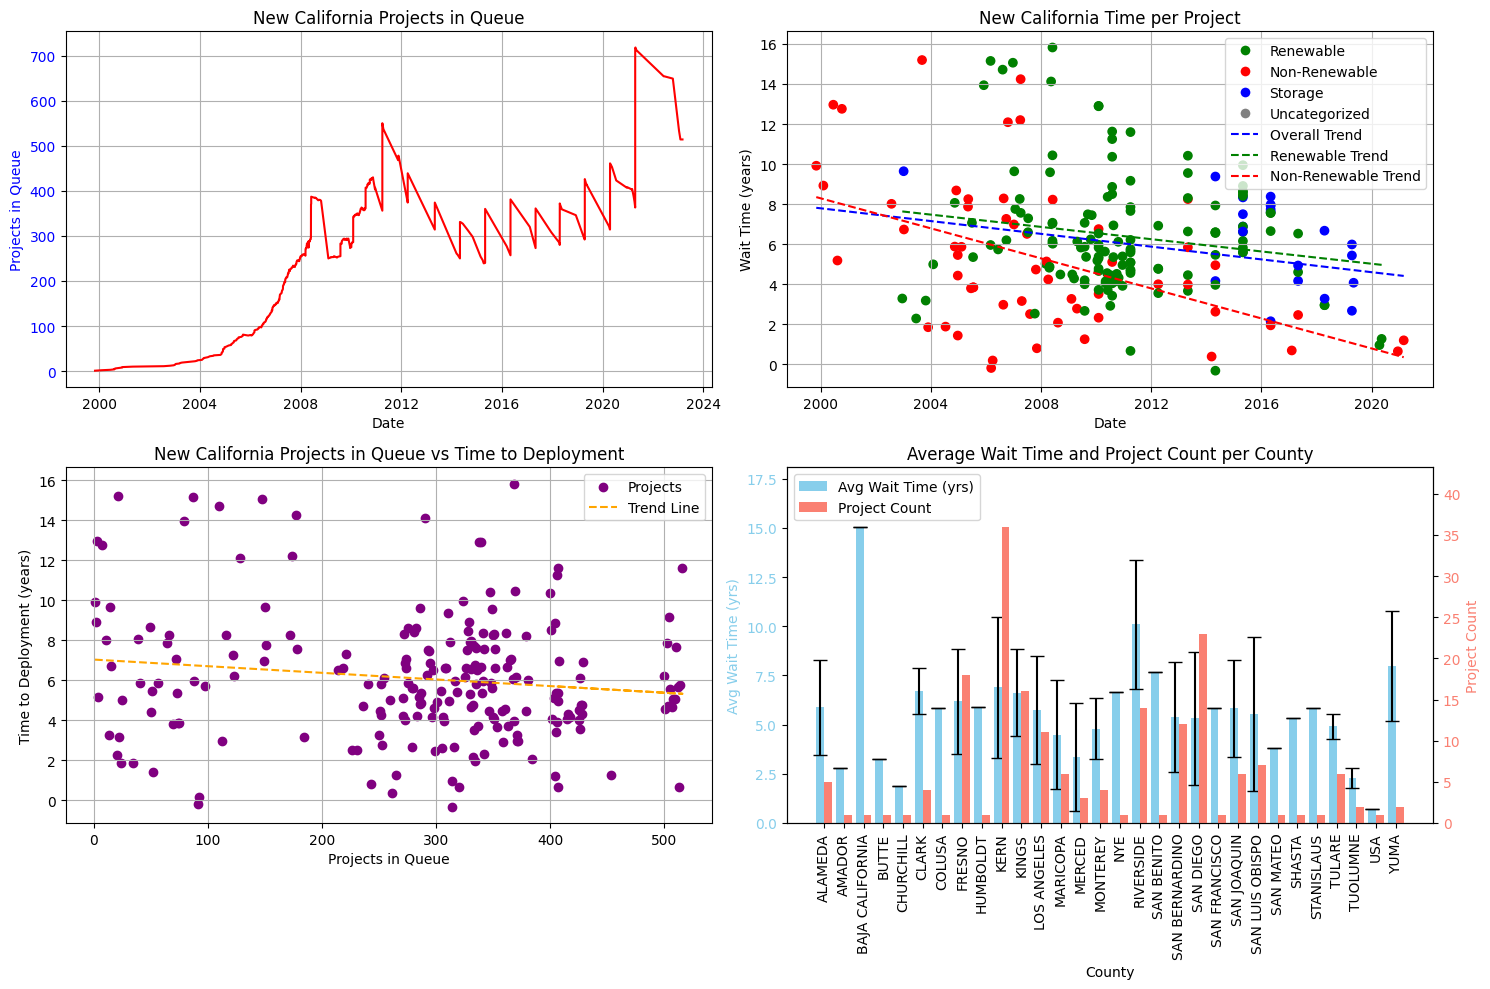

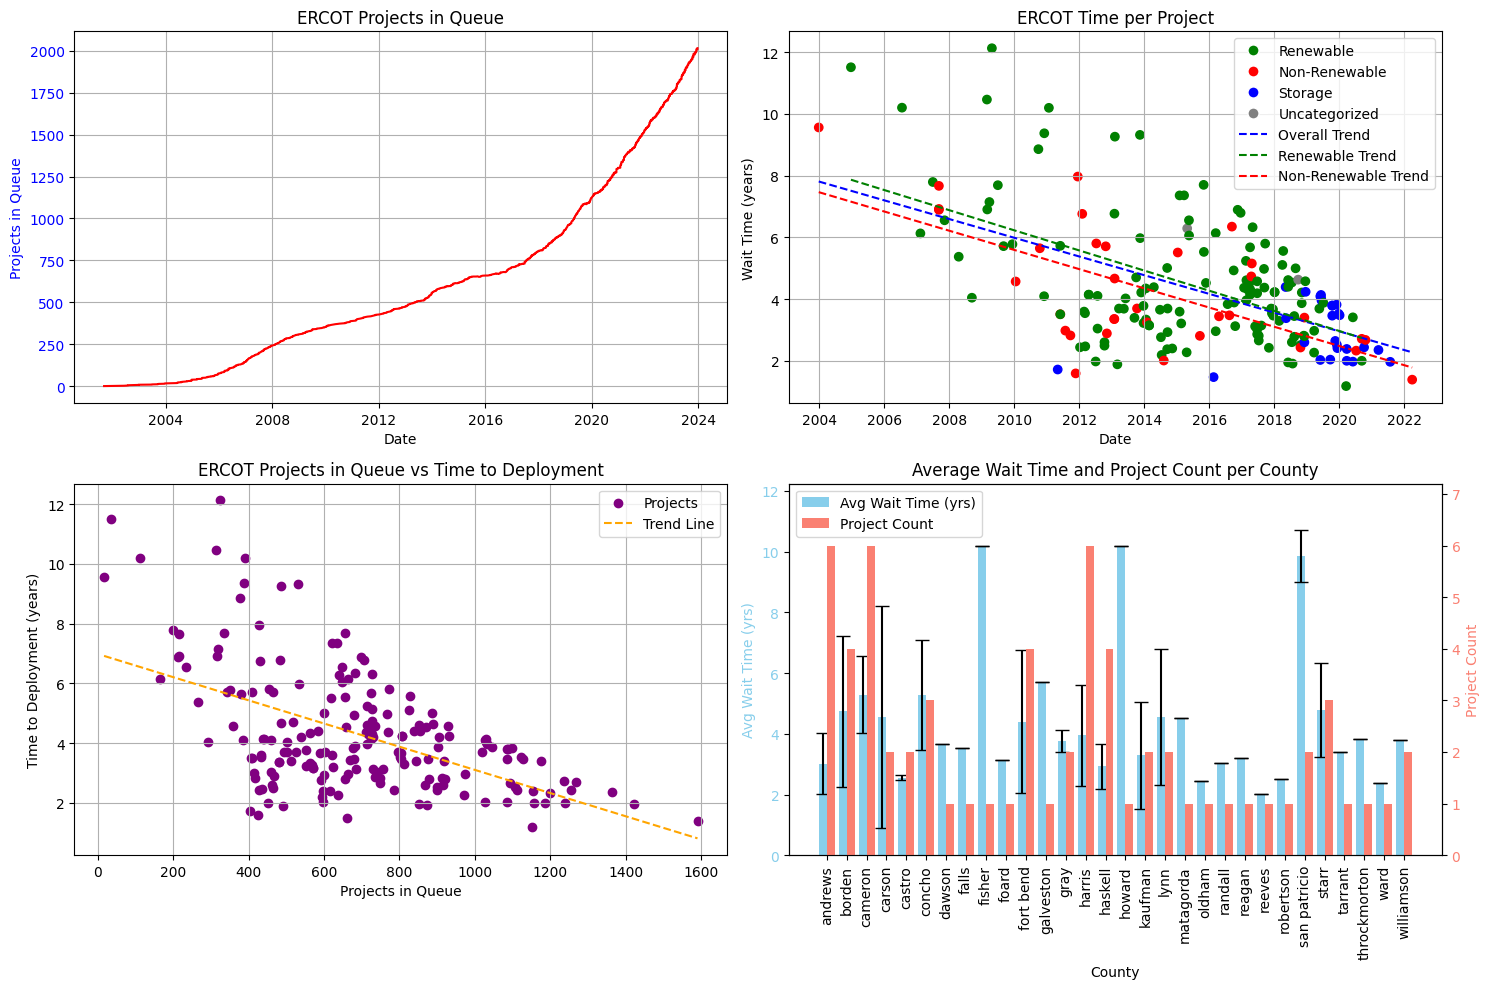

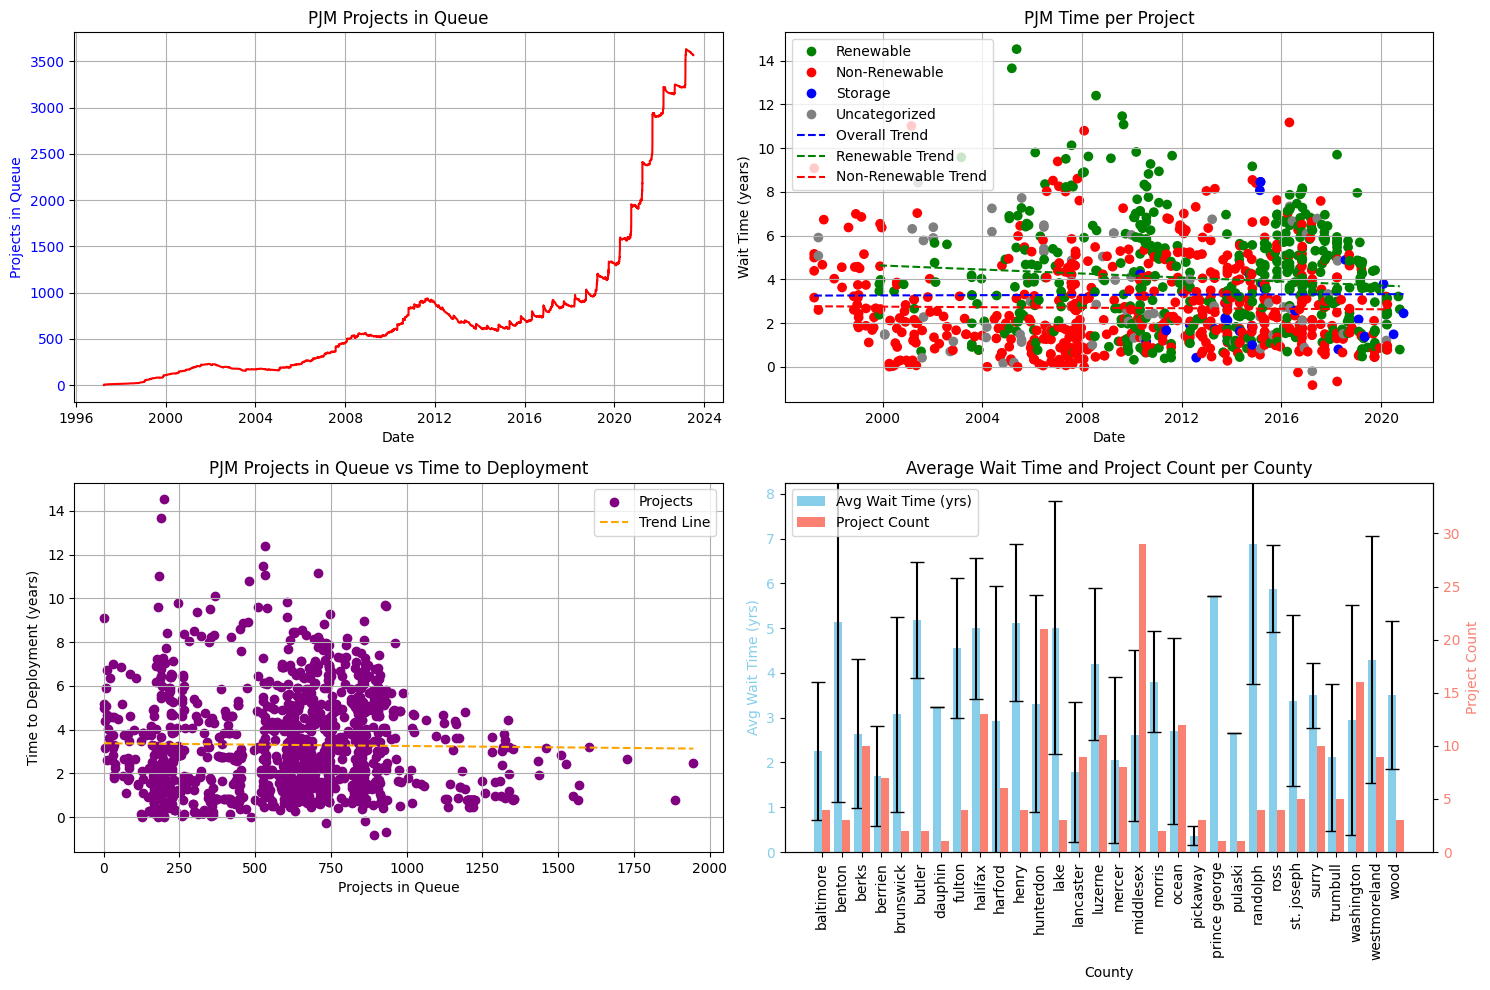

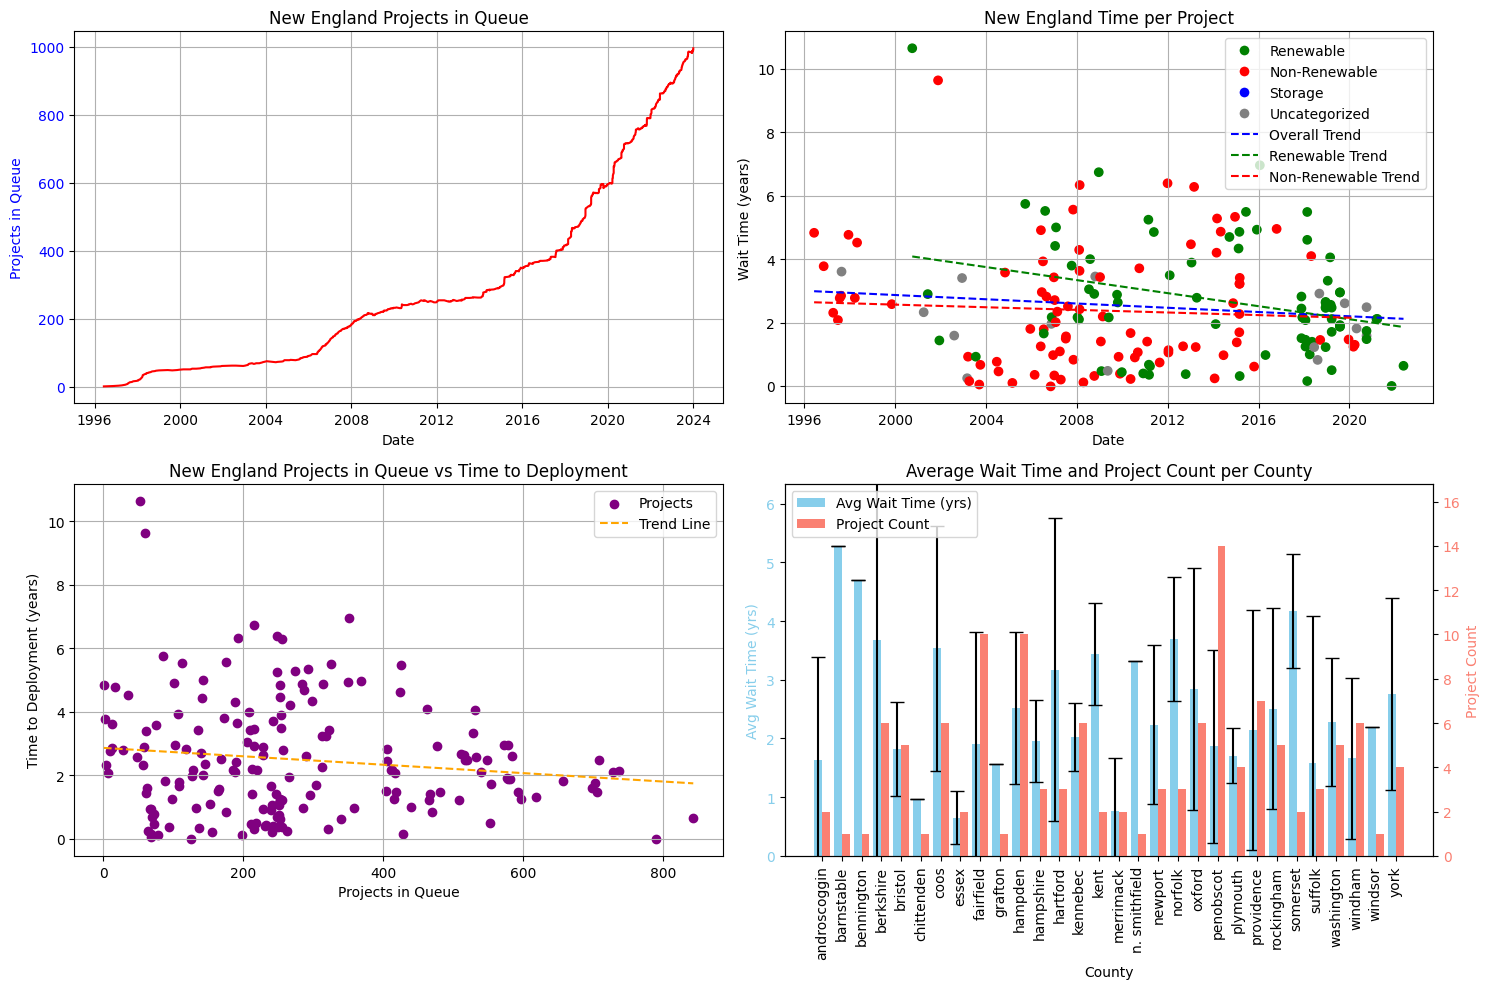

In [79]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


iso_list = {
    "California": sorted_caiso,
    "New California": new_caiso,
    "ERCOT": sorted_ercot,
    "PJM": sorted_pjm,
    "New England": sorted_iso_ne,
}
for name, iso in iso_list.items():
    queue = queue_length(iso, initial_queue=0)
    iso["queue"] = queue
    dates = iso["q_date"]
    completed_iso = iso[iso["on_date"].notna()]
    completed_dates = completed_iso["q_date"]
    time_difference = calculate_difference(completed_iso)




    completed_iso["color"] = completed_iso["type_clean"].apply(get_project_color)
    completed_iso["time_difference"] = time_difference

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Increased height for better spacing
    ax1, ax2, ax3, ax4 = axes.ravel()
    ax1.plot(dates, queue, '-r', label="Projects in Queue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Projects in Queue", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title(f"{name} Projects in Queue")
    ax1.grid()

    ax2.scatter(completed_dates, time_difference, c=completed_iso["color"])
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Wait Time (years)")

    completed_dates_num = completed_dates.map(pd.Timestamp.toordinal)
    overall_coeffs = np.polyfit(completed_dates_num, time_difference, 1)
    overall_fit = np.polyval(overall_coeffs, completed_dates_num)
    ax2.plot(completed_dates, overall_fit, '--b', label="Overall Trend")

    for category, color, label in [
        ("renewable", "green", "Renewable Trend"),
        ("non_renewable", "red", "Non-Renewable Trend"),
    ]:
        type_set = renewable_types if category == "renewable" else non_renewable_types
        filtered = completed_iso[completed_iso["type_clean"].isin(type_set)]

        if not filtered.empty:
            x = filtered["q_date"].map(pd.Timestamp.toordinal)
            y = filtered["time_difference"]
            coeffs = np.polyfit(x, y, 1)
            fit = np.polyval(coeffs, x)
            ax2.plot(filtered["q_date"], fit, '--', color=color, label=label)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Renewable', markerfacecolor='green', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Non-Renewable', markerfacecolor='red', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Storage', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Uncategorized', markerfacecolor='gray', markersize=8),
    ]
    ax2.legend(handles=legend_elements + ax2.get_legend_handles_labels()[0])

    ax2.set_title(f"{name} Time per Project")
    ax2.grid()
    x = completed_iso["queue"]
    y = completed_iso["time_difference"]

    fig.tight_layout()
    # ax3.figure(figsize=(10, 5))
    ax3.scatter(x,y, color= 'purple', label="Projects")
    coeffs = np.polyfit(x, y, 1)
    fit = np.polyval(coeffs, x)
    ax3.plot(x, fit, '--', color='orange', label="Trend Line")
    ax3.legend()
    ax3.set_xlabel("Projects in Queue")
    ax3.set_ylabel("Time to Deployment (years)")
    ax3.set_title(f"{name} Projects in Queue vs Time to Deployment")
    ax3.grid()

        # Plot average wait times per county
        # Calculate average wait times and std
    avg_wait_times = average_wait_times(completed_iso)
    if len(avg_wait_times) > 30:
        avg_wait_times = avg_wait_times.sample(n=30, random_state=42)

    # Sort by county name for consistent plotting
    avg_wait_times = avg_wait_times.sort_values("county_1")
    avg_wait_times.fillna(0, inplace=True)  # Fill NaN values with 0 for plotting

    # Plot setup
    ax_right = ax4.twinx()  # Create second Y-axis
    ax4.set_ylim(bottom=0)
    ax_right.set_ylim(bottom=0)
    ax4.set_ylim(top=avg_wait_times["avg_wait_time"].max() * 1.2)  # Set top limit for left Y-axis
    ax_right.set_ylim(top=avg_wait_times["project_count"].max() * 1.2)  # Set top limit for left Y-axis)

    x = range(len(avg_wait_times))
    bar_width = 0.4

    # Plot avg wait time on the left Y-axis
    ax4.bar(
        [i - bar_width / 2 for i in x],
        avg_wait_times["avg_wait_time"],
        yerr=avg_wait_times["std_wait_time"],
        width=bar_width,
        color='skyblue',
        label="Avg Wait Time (yrs)",
        capsize=5
    )

    # Plot project count on the right Y-axis
    ax_right.bar(
        [i + bar_width / 2 for i in x],
        avg_wait_times["project_count"],
        width=bar_width,
        color='salmon',
        label="Project Count"
    )

    # X-axis formatting
    ax4.set_xticks(x)
    ax4.set_xticklabels(avg_wait_times["county_1"], rotation=90)

    # Labels and title
    ax4.set_xlabel("County")
    ax4.set_ylabel("Avg Wait Time (yrs)", color='skyblue')
    ax_right.set_ylabel("Project Count", color='salmon')
    ax4.set_title("Average Wait Time and Project Count per County")

    # Match color of y-axis tick labels to bars
    ax4.tick_params(axis='y', labelcolor='skyblue')
    ax_right.tick_params(axis='y', labelcolor='salmon')

    # Combine legends
    lines, labels = ax4.get_legend_handles_labels()
    lines2, labels2 = ax_right.get_legend_handles_labels()
    ax4.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()


### Observations:
- Queue Dynamics
The queue on average has been increasing, with the rate at which projects enter the queue increasing throughout the different ISOs.
- Wait times
For projects that are eventually completed, wait times have been decreasing on average, with renewable projects having on average slightly longer wait times throughout. In California specifically, the wait times for non-renewable projects is considerably lower than wait times for renewable projects, as there is noticeably more renewable projects than non-renewable the average wait-times are closer to that of renewables. It is important to note that some projects have negative wait times, for instance "ARLINGTON VALLEY SOLAR ENERGY 2 interconnection request with ID 1040", has a queue date of april 30, 2014, and a completion date of january 3, 2014 (after reading through the Large Generator Interconnection Agreement it seems that there was some sort of typo and the intended year should've been 2017). This same error occurs accross multiple data sources, requiring furhter validation.
- Queue and Wait times
As we know, wait times have been decreasing on average, at the same time, the queue has been steadily increasing over time. When comparing how the size of the queue impacts wait times, we see that there is little to no correlation, if there is a correlation it would be in fact negative. Which makes sense since queue are larger in recent times and wait times are shorter the inverse of what we would expect occurs. Which doesn't necessarily mean that they are negatively correlated, it's more likely that there is very little correlation and they are both dependant on outside factors that we can't model. If that's the case thinking of this issues as a queue might not be the correct approach entirely.
- Counties
For spatial analysis we have also included the average wait times of each county, which could perhaps be included in the model as a way to forecast wait times for projects. As we can see, the standard deviation for wait times accross counties is also really high suggesting that there other factors affecting wait times.
  

We can decide on a few methods of calculating the total queue length, namely we have 3 options in increasing order of complexity

### Option 2

Building upon option 1, we separate the number of projects in the queue according to their type (gas, solar, wind...)

A potential concern would be on how we handle hybrid projects with multiple types, for now let's consider a hybrid projects as contributing to all types of projects that are on the queue

In [165]:
# With this method we will want to add a few extra variables according to types of

def first_exit_projects(list_of_tuples):
    first_exit = list_of_tuples.pop(0)
    first_exit_date = first_exit[-1]
    first_exit_types = first_exit[:3]
    first_exit_capacities = first_exit[3:6]
    return first_exit_date, first_exit_types, first_exit_capacities

def medium_queue_df(iso):
    cateogircal_iso, _ = categorical_change(iso)
    n = cateogircal_iso["type2"].max()

    # Initialize matrix with shape (rows = projects over time, columns = type counts)
    X = np.zeros((len(cateogircal_iso), n + 1))

    list_of_tuples = exited_projects(cateogircal_iso)
    if list_of_tuples:
        first_exit_date, first_exit_type, _ = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_type = pd.Timestamp("2099-12-31"), []

    for i, (_, row) in enumerate(cateogircal_iso.iterrows()):
        current_date = row['q_date']
        types = (row["type1"], row["type2"], row["type3"])

        if i > 0:
            X[i, :] = X[i - 1, :]

        for t in types:
            if pd.notna(t):
                X[i, int(t)] += 1

        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for t in first_exit_type:
                if pd.notna(t):
                    X[i, int(t)] -= 1
            if list_of_tuples:
                first_exit_date, first_exit_type, _ = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # Generate descriptive column names
    count_cols =  [f"n_type_{k}" for k in range(n + 1)]

    # out_df = cateogircal_iso.copy()
    # out_df[count_cols] = X

    # return out_df
    out_df = pd.DataFrame(X, columns=count_cols)
    # remove the last column
    out_df = out_df.iloc[:, :-1]  # Remove the last column (n_type_n)
    return out_df


# medium_queue = medium_queue_df(new_caiso)
# medium_queue
# df.to_csv("New_England_medium_queue.csv")

### Option 3
Building upon option 2, we include not only the type of energy source but we also include the capacity of each type

In [166]:
# We might want to consider adding more parameters to what we're working with
# Mainly, size of the queue in mw per type
# We'll add

    # return max(iso["type1"].max())
def complex_queue_df(iso):
    categorical_iso, _ = categorical_change(iso)  # ensures types are consistent
    n = categorical_iso["type2"].max()

    # Matrix with columns: [count_0, ..., count_n, mw_0, ..., mw_n]
    X = np.zeros((len(categorical_iso), (n + 1) * 2))

    list_of_tuples = exited_projects(categorical_iso)
    if list_of_tuples:
        first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_types, first_exit_capacities = pd.Timestamp("2099-12-31"), [], []

    for i, (_, row) in enumerate(categorical_iso.iterrows()):
        current_date = row['q_date']
        current_types = (row["type1"], row["type2"], row["type3"])
        current_capacities = (row["mw1"], row["mw2"], row["mw3"])

        if i > 0:
            X[i, :] = X[i - 1, :]

        for idx, t in enumerate(current_types):
            if pd.notna(t):  # guard against NaN types
                X[i, t] += 1
                if not pd.isna(current_capacities[idx]):
                    X[i, t + n + 1] += current_capacities[idx]

        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for idx, t in enumerate(first_exit_types):
                if pd.notna(t):
                    X[i, t] -= 1
                    X[i, t + n + 1] -= first_exit_capacities[idx]
            if list_of_tuples:
                first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # Remove any over-indexed type columns if needed
    if X.shape[1] == (n + 1) * 2:
        X = np.delete(X, [n, n*2 + 1], axis=1)

    # Create column names
    count_cols = [f"n_type_{k}" for k in range(n + 1) if k != n]
    mw_cols = [f"mw_type_{k}" for k in range(n + 1) if k != n]
    column_names = count_cols + mw_cols

    # out_df = iso.copy()
    # out_df[column_names] = X

    # return out_df
    out_df = pd.DataFrame(X, columns=column_names)
    out_df = out_df.iloc[:, :-1]
    return out_df

print(medium_queue_df(sorted_caiso).head())
# np.set_printoptions(threshold=np.inf)
# complex = complex_queue_df(new_caiso)
# df = pd.concat([sorted_iso_ne,complex], axis = 1)
# df.to_csv("New_England_complex_queue.csv")


   n_type_0  n_type_1  n_type_2  n_type_3  n_type_4  n_type_5  n_type_6  \
0       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       2.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       3.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       4.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       5.0       0.0       0.0       0.0       0.0       0.0   

   n_type_7  n_type_8  n_type_9  n_type_10  n_type_11  n_type_12  
0       0.0       0.0       0.0        0.0        0.0        0.0  
1       0.0       0.0       0.0        0.0        0.0        0.0  
2       0.0       0.0       0.0        0.0        0.0        0.0  
3       0.0       0.0       0.0        0.0        0.0        0.0  
4       0.0       0.0       0.0        0.0        0.0        0.0  


As the above methods seem to include a large amount of variables for a relatiely small data set, it would be wiser to categorize the data into smaller sub-categories, for example separate them solely between renewables and non-renewables

In [62]:
def queue_by_category(iso):
    renewable_iso = renewable_split(iso) # this converts type1/2/3 into 1, 2, 3 (renewable, non-renewable, storage)

    # Initialize matrix: rows = each project over time, cols = [renewable, non-renewable, storage]
    X = np.zeros((len(renewable_iso), 3))

    # Get and sort exits
    list_of_tuples = exited_projects(renewable_iso)
    if list_of_tuples:
        first_exit_date, first_exit_types, _ = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_types = pd.Timestamp("2099-12-31"), []

    for i, (_, row) in enumerate(renewable_iso.iterrows()):
        current_date = row['q_date']
        types = (row["type1"], row["type2"], row["type3"])

        # Inherit previous values
        if i > 0:
            X[i, :] = X[i - 1, :]

        # Add current project's types
        for t in types:
            if t == 1:
                X[i, 0] += 1  # renewable
            elif t == 2:
                X[i, 1] += 1  # non-renewable
            elif t == 3:
                X[i, 2] += 1  # storage

        # Subtract exited projects until the current date
        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for t in first_exit_types:
                if t == 1:
                    X[i, 0] -= 1
                elif t == 2:
                    X[i, 1] -= 1
                elif t == 3:
                    X[i, 2] -= 1
            if list_of_tuples:
                first_exit_date, first_exit_types, _ = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # Optional: convert to DataFrame
    # out_df = renewable_iso.copy()
    out_df = pd.DataFrame(index=renewable_iso.index)
    out_df[["n_renewable", "n_non_renewable", "n_storage"]] =X
    return out_df

def queue_by_category_and_capacity(iso):
    renewable_iso = renewable_split(iso)  # ensures type1/2/3 are 1/2/3 (renewable, non-renewable, storage)

    X = np.zeros((len(renewable_iso), 6))

    list_of_tuples = exited_projects(renewable_iso)
    if list_of_tuples:
        first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_types, first_exit_capacities = pd.Timestamp("2099-12-31"), [], []

    for i, (_, row) in enumerate(renewable_iso.iterrows()):
        current_date = row['q_date']
        types = (row["type1"], row["type2"], row["type3"])
        capacities = (row["mw1"], row["mw2"], row["mw3"])

        # Inherit previous values
        if i > 0:
            X[i, :] = X[i - 1, :]

        for idx, t in enumerate(types):
            if t == 1:
                X[i, 0] += 1
                if not pd.isna(capacities[idx]):
                    X[i, 3] += capacities[idx]
            elif t == 2:
                X[i, 1] += 1
                if not pd.isna(capacities[idx]):
                    X[i, 4] += capacities[idx]
            elif t == 3:
                X[i, 2] += 1
                if not pd.isna(capacities[idx]):
                    X[i, 5] += capacities[idx]

        # Subtract exited projects
        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for idx, t in enumerate(first_exit_types):
                if t == 1:
                    X[i, 0] -= 1
                    X[i, 3] -= first_exit_capacities[idx]
                elif t == 2:
                    X[i, 1] -= 1
                    X[i, 4] -= first_exit_capacities[idx]
                elif t == 3:
                    X[i, 2] -= 1
                    X[i, 5] -= first_exit_capacities[idx]
            if list_of_tuples:
                first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # out_df = renewable_iso.copy()
    out_df = pd.DataFrame(index=renewable_iso.index)
    out_df[[
        "n_renewable", "n_non_renewable", "n_storage",
        "mw_renewable", "mw_non_renewable", "mw_storage"
    ]] = X

    return out_df

# medium_queue = complex_queue_df(sorted_caiso)
# medium_queue

n_type_0  n_type_1  n_type_2  n_type_3  n_type_4  n_type_5  n_type_6  \
0          0.0       1.0       0.0       0.0       0.0       0.0       0.0   
1          0.0       2.0       0.0       0.0       0.0       0.0       0.0   
2          0.0       3.0       0.0       0.0       0.0       0.0       0.0   
3          0.0       4.0       0.0       0.0       0.0       0.0       0.0   
4          0.0       5.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
2818       0.0     183.0     179.0    1371.0    1237.0      15.0      89.0   
2819       0.0     183.0     179.0    1372.0    1238.0      15.0      89.0   
2820       0.0     183.0     179.0    1373.0    1239.0      15.0      89.0   
2821       0.0     183.0     179.0    1374.0    1239.0      15.0      89.0   
2822       0.0     183.0     179.0    1375.0    1239.0      15.0      89.0   

      n_type_7  n_type_8  n_type_9  ...  mw_type_2  mw_type_3  mw_type_4  \
0          0.0       0.0       0.0  ...        0.0        0.0        0.0   
1          0.0       0.0       0.0  ...        0.0        0.0        0.0   
2          0.0       0.0       0.0  ...        0.0        0.0        0.0   
3          0.0       0.0       0.0  ...        0.0        0.0        0.0   
4          0.0       0.0       0.0  ...        0.0        0.0        0.0   
...        ...       ...       ...  ...        ...        ...        ...   
2818       9.0       2.0      17.0  ...    72786.1   389663.0   282793.6   
2819       9.0       2.0      17.0  ...    72786.1   390026.0   283156.6   
2820       9.0       2.0      17.0  ...    72786.1   390543.0   283673.6   
2821       9.0       2.0      17.0  ...    72786.1   390799.0   283673.6   
2822       9.0       2.0      17.0  ...    72786.1   390809.0   283673.6   

      mw_type_5  mw_type_6  mw_type_7  mw_type_8  mw_type_9  mw_type_10  \
0           0.0        0.0        0.0        0.0        0.0         0.0   
1           0.0        0.0        0.0        0.0        0.0         0.0   
2           0.0        0.0        0.0        0.0        0.0         0.0   
3           0.0        0.0        0.0        0.0        0.0         0.0   
4           0.0        0.0        0.0        0.0        0.0         0.0   
...         ...        ...        ...        ...        ...         ...   
2818     3933.4    23977.4     1659.4       95.0    19067.0      2402.0   
2819     3933.4    23977.4     1659.4       95.0    19067.0      2402.0   
2820     3933.4    23977.4     1659.4       95.0    19067.0      2402.0   
2821     3933.4    23977.4     1659.4       95.0    19067.0      2402.0   
2822     3933.4    23977.4     1659.4       95.0    19067.0      2402.0   

      mw_type_11  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
...          ...  
2818        12.0  
2819        12.0  
2820        12.0  
2821        12.0  
2822        12.0  

[2823 rows x 25 columns]

In [171]:
import pandas as pd

iso_data = {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
    "New Caiso": new_caiso,
    "PJM": sorted_pjm
}

functions = [queue_by_category_and_capacity,
              complex_queue_df]

columns_interest = [
    "q_id", "q_status", "q_date", "wd_date", "on_date",
     "county_1","type1", "type2", "type3","mw1","mw2","mw3"
]

with pd.ExcelWriter("all_isos_by_function.xlsx", engine="openpyxl") as writer:
    for iso_name, iso in iso_data.items():
        for func in functions:
            X = func(iso)

            df = iso[columns_interest].copy()

            df = pd.concat([df, X], axis=1)
            # print(df)
            # break
            sheet_name = f"{iso_name}_{func.__name__}"[:31]
            # Excel sheet name limit

            df.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Written sheet: {sheet_name}")


Written sheet: Caiso_queue_by_category_and_cap
Written sheet: Caiso_complex_queue_df
Written sheet: Ercot_queue_by_category_and_cap
Written sheet: Ercot_complex_queue_df
Written sheet: NE_queue_by_category_and_capaci
Written sheet: NE_complex_queue_df
Written sheet: New Caiso_queue_by_category_and
Written sheet: New Caiso_complex_queue_df
Written sheet: PJM_queue_by_category_and_capac
Written sheet: PJM_complex_queue_df


In [ ]:

# def data_split(iso, option = 1,time_unit="years", randomness=True):
#     iso["queue"] = queue_length(iso)
#     iso = iso[iso["on_date"].notna()]  # only select projects that have been deployed
#     iso["time_difference"] = calculate_difference(iso, time_unit)
#     categorical_columns = ["type1", "type2", "type3"]
#     full_categorical_change(iso)
#     X = np.nan_to_num(
#         iso[["type1", "type2", "type3", "mw1", "mw2", "mw3", "queue"]].to_numpy()
#     ) # the size/time + mw of the queue per type of the last few projects
#     if option ==2:
#         medium_queue = medium_queue_df(iso).to_numpy()
#         X = np.concatenate((X,medium_queue),axis = 1)
#     elif option ==3:
#         complex_queue = complex_queue_df(iso)
#         X = np.concatenate((X,complex_queue),axis = 1)
#     y = np.nan_to_num(iso["time_difference"].to_numpy())
#     if randomness:
#         return train_test_split(X, y, test_size=0.3, random_state=42)
#     else:
#         return train_test_split(X, y, test_size=0.3)

def chronological_split(X, y, train_frac=0.7):
    split_index = int(len(X) * train_frac)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    return X_train, X_test, y_train, y_test

def data_split(iso, queue_func,time_unit="years", randomness=True):
    iso["queue"] = queue_length(iso)
    iso = iso[iso["on_date"].notna()]  # only select projects that have been deployed
    iso["time_difference"] = calculate_difference(iso, time_unit)
    categorical_columns = ["type1", "type2", "type3"]
    categorical_iso = categorical_change(iso)
    X = np.nan_to_num(
        categorical_iso[["type1", "type2", "type3", "mw1", "mw2", "mw3", "queue"]].to_numpy()
    ) # the size/time + mw of the queue per type of the last few projects
    queue_df = queue_func(iso)
    # print("This is the current queue\n",queue_df)
    X = np.concatenate((X, queue_df.to_numpy()), axis=1)
    y = np.nan_to_num(iso["time_difference"].to_numpy())
    if randomness:
        return train_test_split(X, y, test_size=0.3, random_state=41)
    else:
        print("Using chronological split")
        return chronological_split(X, y, train_frac=0.7)
# def data_split(iso, queue_func, time_unit="days", randomness=True):
#     # Compute queue length (basic feature)
#     iso["queue"] = queue_length(iso)

#     # Keep only deployed projects
#     iso = iso[iso["on_date"].notna()].copy()

#     # Calculate target variable: time to deployment
#     iso["time_difference"] = calculate_difference(iso, time_unit)

#     # Encode categories
#     categorical_columns = ["type1", "type2", "type3"]
#     full_categorical_change(iso)

#     # Base input features
#     X_base = np.nan_to_num(iso[["type1", "type2", "type3", "mw1", "mw2", "mw3", "queue"]].to_numpy())

#     # Add extra features using provided queue function
#     queue_df = queue_func(iso)
#     extra_features = queue_df.drop(columns=iso.columns, errors="ignore")
#     X_extra = np.nan_to_num(extra_features.to_numpy())

#     # Combine base and extra features
#     X = np.concatenate((X_base, X_extra), axis=1)
#     y = np.nan_to_num(iso["time_difference"].to_numpy())

#     # Perform the train/test split
#     return train_test_split(X, y, test_size=0.3, random_state=42 if randomness else None)


#### Helper plotter function

In [74]:
def predict_and_plot(algorithm,iso, feature_function,name,randomness=False):
    seen, unseen, predicted, actual = algorithm(iso,feature_function, randomness=randomness)
    print(f"R^2 Performance on seen data for {name} :{seen :.4f} \n")
    # print(f"R^2 Performance on unseen data for {name} :{unseen:.4f} \n")
    plt.figure(figsize=(10, 5))
    plt.plot(actual[:40], label='Actual')
    plt.plot(predicted[:40], label='Predicted',linestyle='--')
    plt.xlabel('Project Index')
    plt.ylabel('Time to Deployment (years)')
    plt.title(rf'Predicted vs Actual Time to Deployment for {name}, $R^2$={unseen:.4f}')
    plt.legend()
    plt.grid()


### Linear Regression for Deployed  Power Plants

This is the current queue
      n_type_0  n_type_1  n_type_2  n_type_3  n_type_4  n_type_5  n_type_6  \
0         0.0       1.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       2.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       3.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       4.0       0.0       0.0       0.0       0.0       0.0   
4         0.0       5.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
132       0.0       3.0       5.0       9.0       1.0      19.0       1.0   
133       0.0       1.0       6.0       6.0       0.0      12.0       1.0   
134       0.0       1.0       6.0       6.0       0.0      13.0       1.0   
135       0.0       2.0       6.0       6.0       0.0       8.0       1.0   
136       0.0       3.0       6.0       6.0       0.0       7.0       1.0   

     n_type_7  n_type_8  
0         0.0       0.

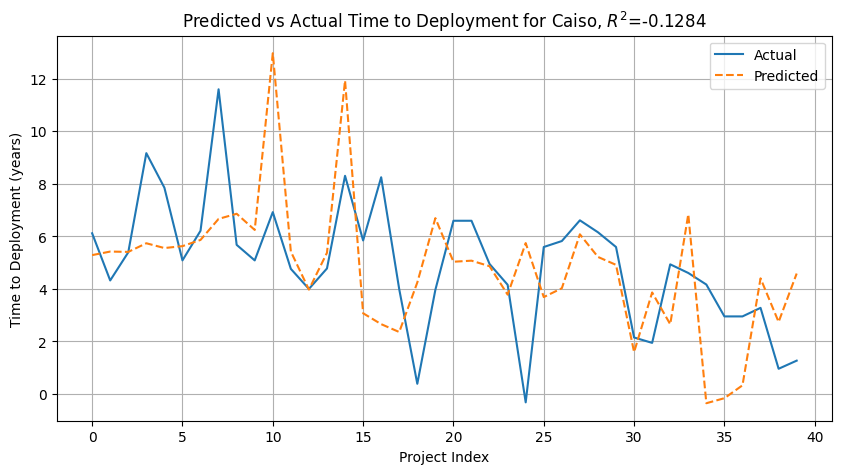

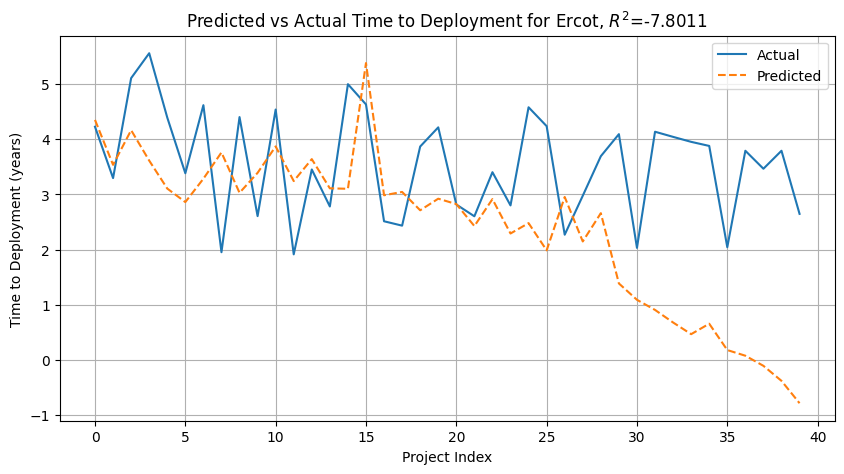

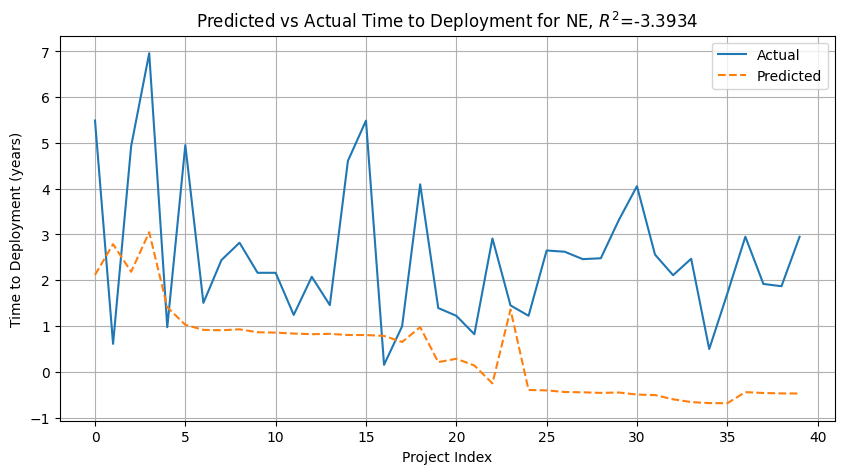

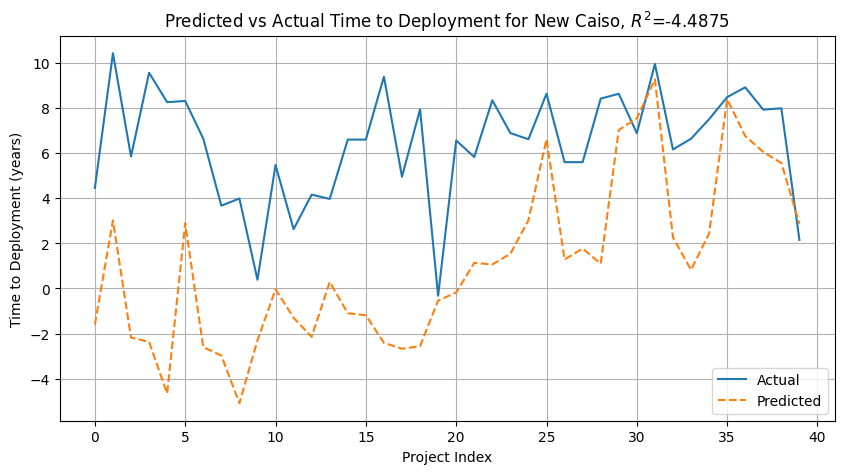

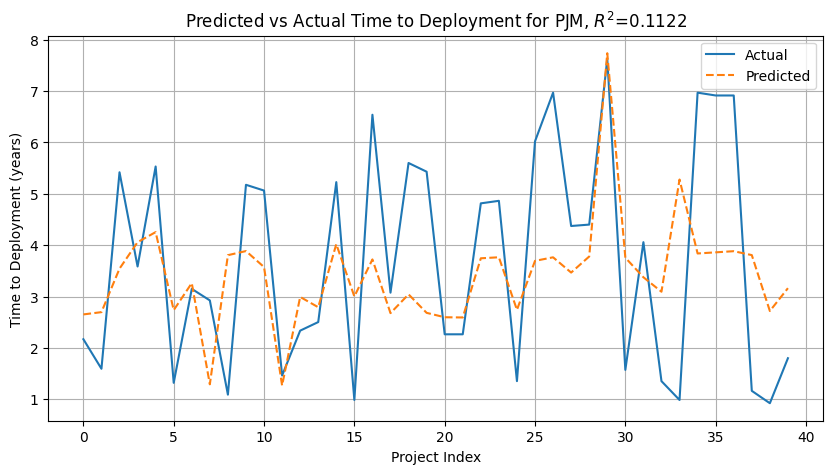

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def linear_regression(iso,function,randomness=False):

    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)
    return r_2_seen, r2_unseen_data, y_pred, y_test

n=10
method_dict = {}
for iso_name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
    "New Caiso": new_caiso,
    "PJM": sorted_pjm
}.items():
    # print(f"Predicting for {name} using linear regression...")
    # for feature_function in [medium_queue_df, complex_queue_df, queue_by_category,queue_by_category_and_capacity]:
    #     name = feature_function.__name__
    #     method_dict[name] = []
    #     r2_list = []
    #     for _ in range(n):
    #         r_2_seen, r2_unseen_data, y_pred, y_test = linear_regression(iso, feature_function, randomness=True)
    #         r2_list.append(r2_unseen_data)
    #     method_dict[name].append(np.mean(r2_list))
    # print(method_dict)




    predict_and_plot(
        linear_regression, iso, medium_queue_df, iso_name,randomness=False
    )

Aside from PJM which has shown to have steady wait times over time, if the projects are chronologically ordered, linear regression performs poorly as it has difficulty handling the decreasing trend over time. 

This is the current queue
       n_renewable  n_non_renewable  n_storage
3735          0.0              1.0        0.0
2496          0.0              2.0        0.0
2400          0.0              3.0        0.0
4249          0.0              4.0        0.0
4304          0.0              5.0        0.0
...           ...              ...        ...
3407         24.0              5.0        9.0
2310         18.0              2.0        6.0
3560         19.0              2.0        6.0
4042         14.0              3.0        6.0
4620         13.0              4.0        6.0

[137 rows x 3 columns]
R^2 Performance on seen data for Caiso :0.8566 

This is the current queue
       n_renewable  n_non_renewable  n_storage
6992          0.0              1.0        0.0
6721          1.0              1.0        0.0
7491          2.0              1.0        0.0
6227          3.0              1.0        0.0
7288          4.0              1.0        0.0
...           ...              ...        ...

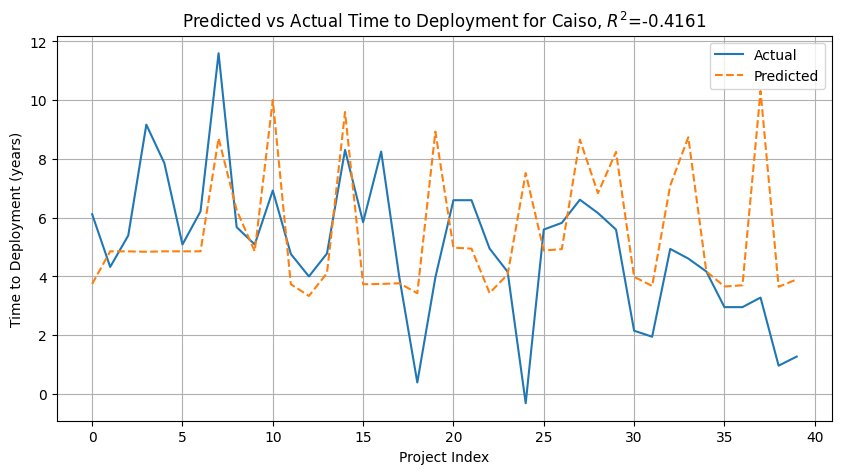

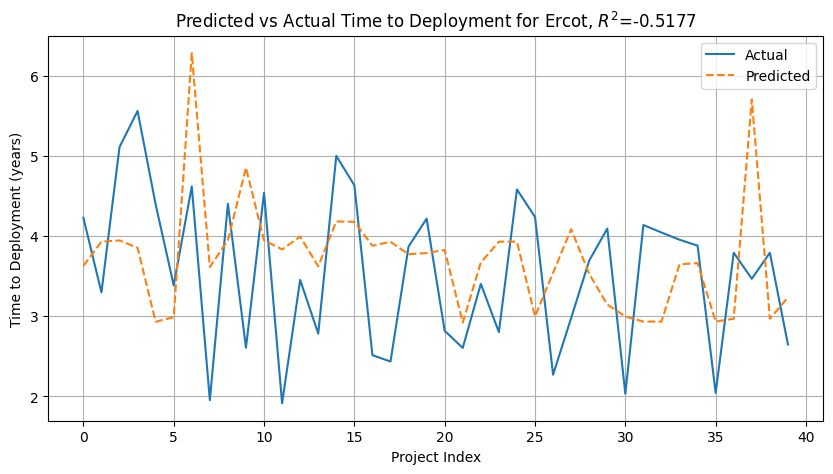

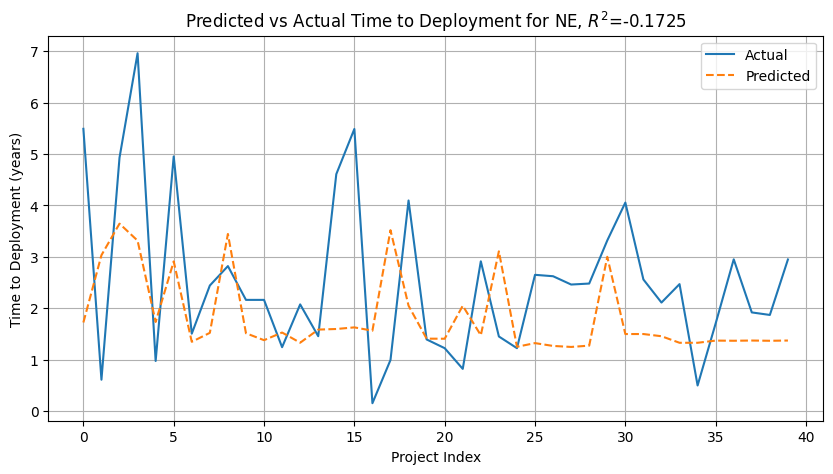

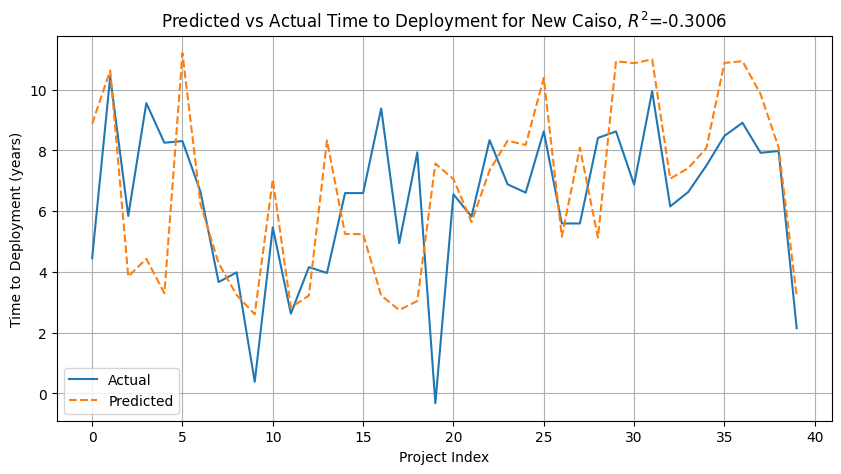

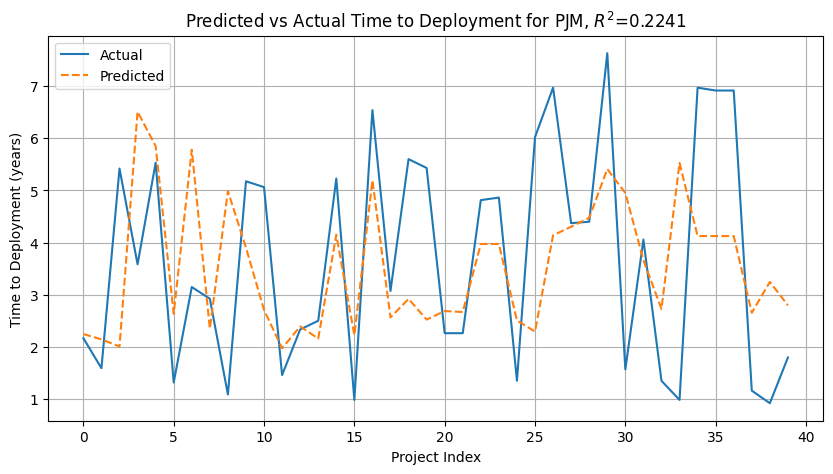

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


def random_forests(iso,function,randomness = False):

    X_train, X_test, y_train, y_test = data_split(iso ,function, randomness=randomness)
    param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
    regressor = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                            param_grid, n_iter=20, cv=5, scoring="r2", n_jobs=-1)

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)
    return r_2_seen, r2_unseen_data, y_pred, y_test



for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
    "New Caiso": new_caiso,
    "PJM": sorted_pjm
}.items():
    predict_and_plot(
        random_forests, iso, queue_by_category, name, randomness=False
    )

include queue times, in the previous 4 or 5 projects

This is the current queue
       n_renewable  n_non_renewable  n_storage
3735          0.0              1.0        0.0
2496          0.0              2.0        0.0
2400          0.0              3.0        0.0
4249          0.0              4.0        0.0
4304          0.0              5.0        0.0
...           ...              ...        ...
3407         24.0              5.0        9.0
2310         18.0              2.0        6.0
3560         19.0              2.0        6.0
4042         14.0              3.0        6.0
4620         13.0              4.0        6.0

[137 rows x 3 columns]
R^2 Performance on seen data for Caiso :0.7191 

This is the current queue
       n_renewable  n_non_renewable  n_storage
6992          0.0              1.0        0.0
6721          1.0              1.0        0.0
7491          2.0              1.0        0.0
6227          3.0              1.0        0.0
7288          4.0              1.0        0.0
...           ...              ...        ...

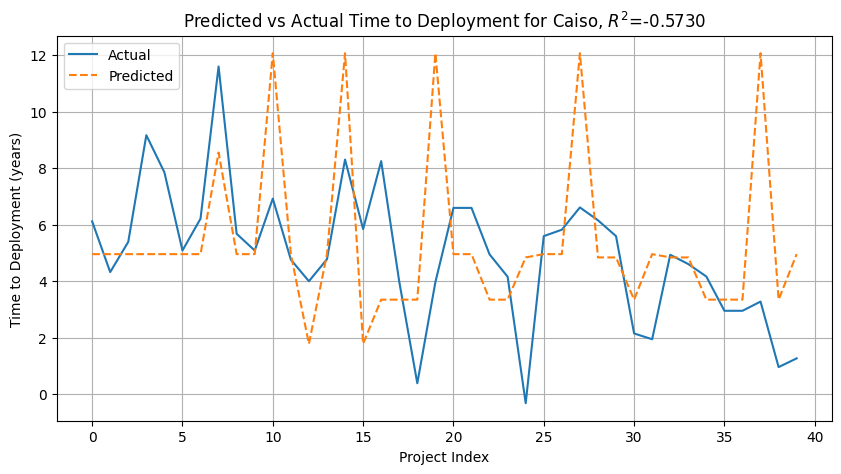

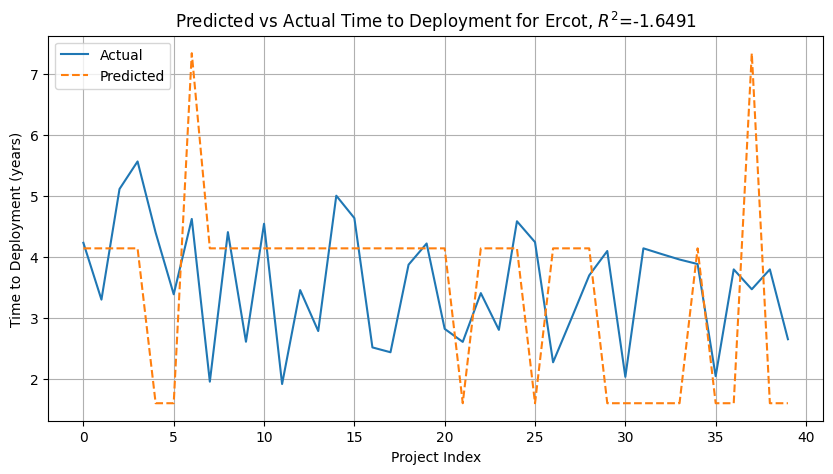

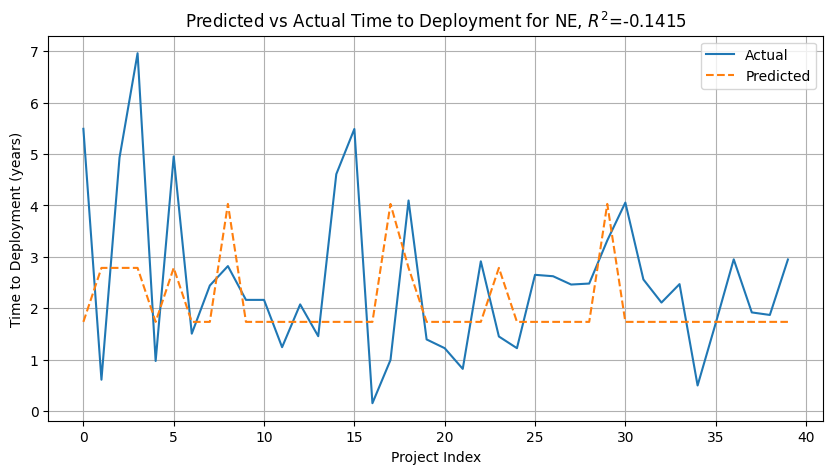

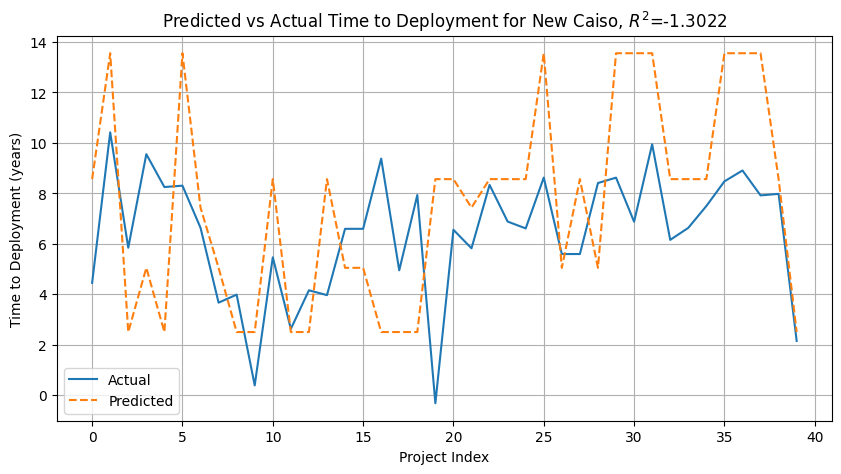

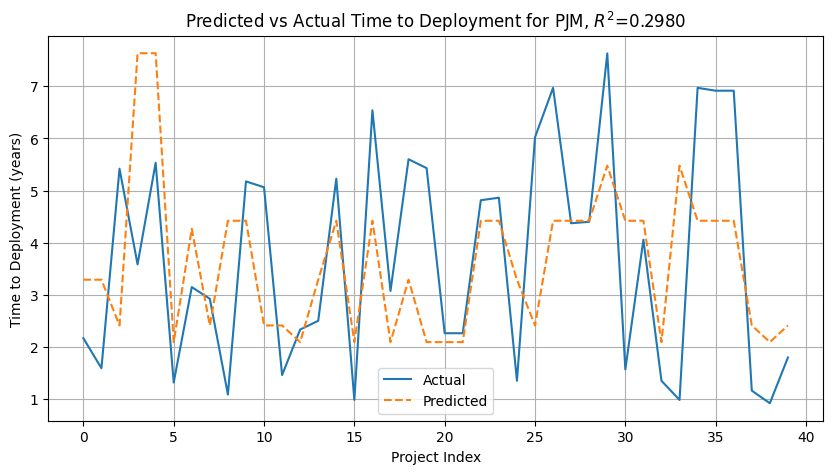

In [95]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


def decision_tree_cv(iso, function, randomness=False):
    """Train and evaluate a Decision Tree Regressor with cross-validation."""

    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)

    # Define model and parameter grid
    regressor = DecisionTreeRegressor(random_state=42)
    param_grid = {
        'max_depth': [3, 5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(
        regressor,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predict
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    r2_seen = r2_score(y_train, y_pred_train)
    r2_unseen = r2_score(y_test, y_pred)

    return r2_seen, r2_unseen, y_pred, y_test




for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
    "New Caiso": new_caiso,
    "PJM": sorted_pjm
}.items():
    predict_and_plot(
        decision_tree_cv, iso, queue_by_category,name, randomness=False
    )

### Gradient Boosted Trees (XGBoost)

This is the current queue
      n_type_0  n_type_1  n_type_2  n_type_3  n_type_4  n_type_5  n_type_6  \
0         0.0       1.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       2.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       3.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       4.0       0.0       0.0       0.0       0.0       0.0   
4         0.0       5.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
132       0.0       3.0       5.0       9.0       1.0      19.0       1.0   
133       0.0       1.0       6.0       6.0       0.0      12.0       1.0   
134       0.0       1.0       6.0       6.0       0.0      13.0       1.0   
135       0.0       2.0       6.0       6.0       0.0       8.0       1.0   
136       0.0       3.0       6.0       6.0       0.0       7.0       1.0   

     n_type_7  n_type_8  
0         0.0       0.

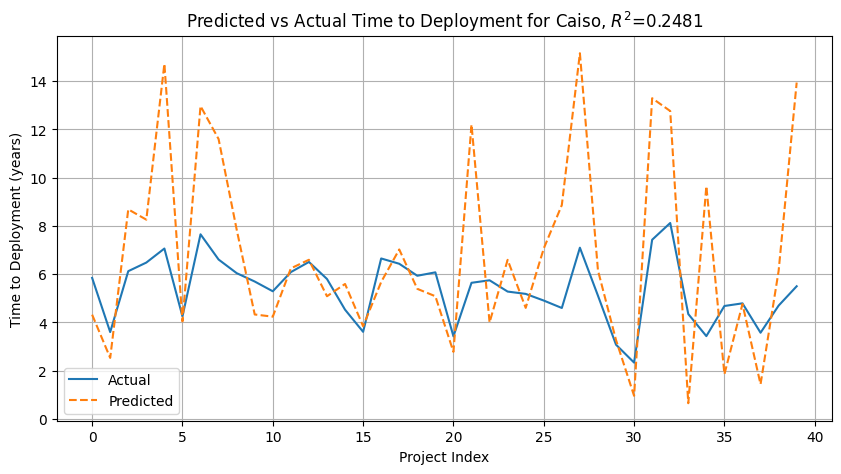

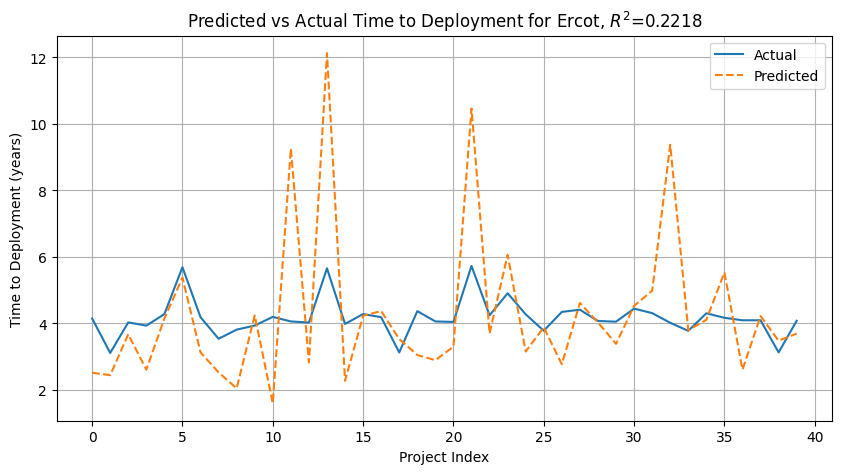

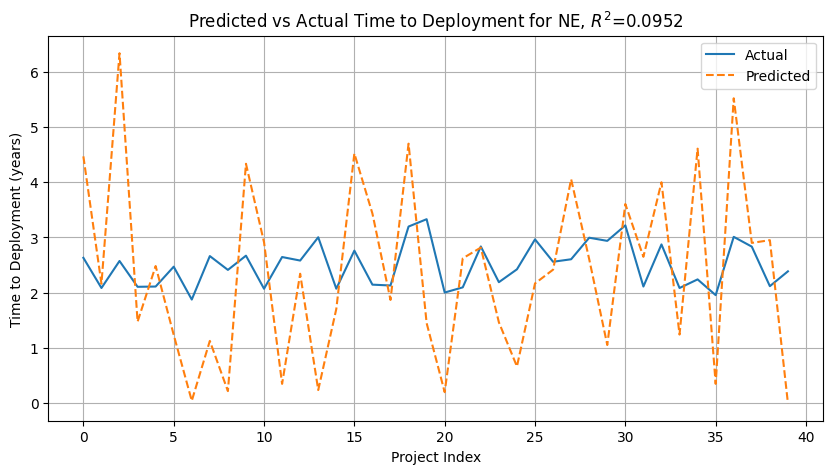

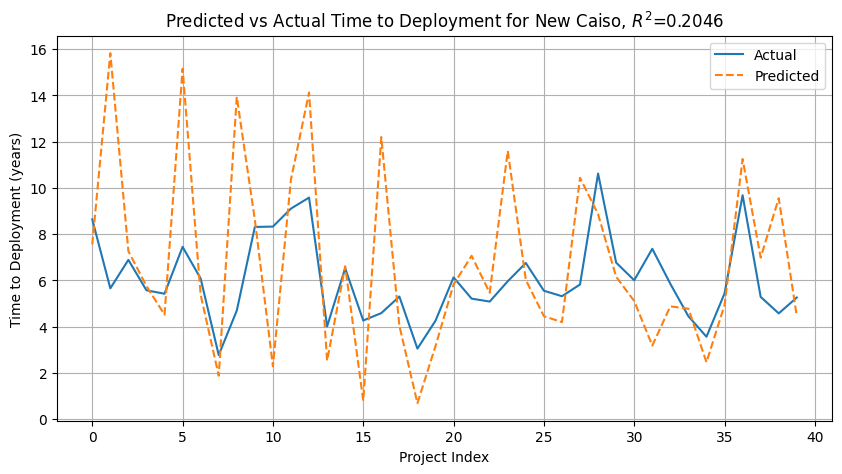

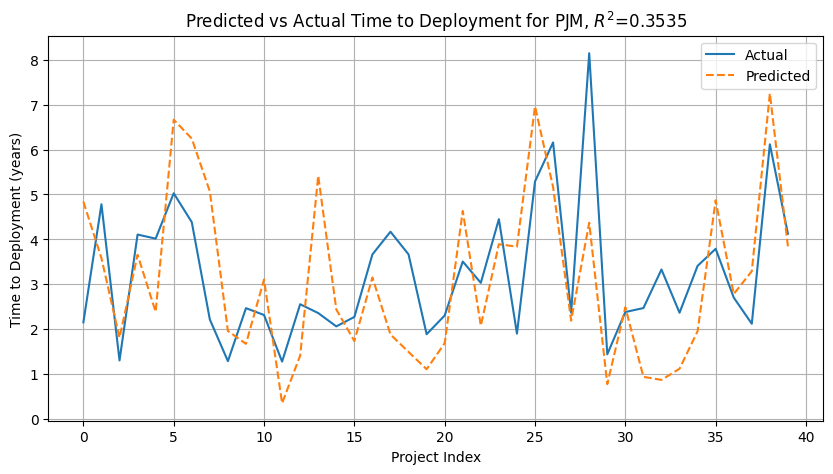

In [103]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from scipy.stats import randint, uniform

def xgboost_cv(iso, function, randomness=False):
    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)

    # Define the model
    model = XGBRegressor(objective='reg:squarederror', seed=42)

    # Hyperparameter distributions
    param_distributions = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
    }

    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_distributions,
        n_iter=30,  # Number of random parameter sets to try
        cv=5,
        scoring='r2',
        verbose=0,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    r2_seen = r2_score(y_train, y_pred_train)
    r2_unseen = r2_score(y_test, y_pred)

    return r2_seen, r2_unseen, y_test, y_pred
for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
    "New Caiso": new_caiso,
    "PJM": sorted_pjm
}.items():
    predict_and_plot(
        xgboost_cv, iso, medium_queue_df, name, randomness=True
    )


### Ridge

This is the current queue
      n_type_0  n_type_1  n_type_2  n_type_3  n_type_4  n_type_5  n_type_6  \
0         0.0       1.0       0.0       0.0       0.0       0.0       0.0   
1         0.0       2.0       0.0       0.0       0.0       0.0       0.0   
2         0.0       3.0       0.0       0.0       0.0       0.0       0.0   
3         0.0       4.0       0.0       0.0       0.0       0.0       0.0   
4         0.0       5.0       0.0       0.0       0.0       0.0       0.0   
..        ...       ...       ...       ...       ...       ...       ...   
132       0.0       3.0       5.0       9.0       1.0      19.0       1.0   
133       0.0       1.0       6.0       6.0       0.0      12.0       1.0   
134       0.0       1.0       6.0       6.0       0.0      13.0       1.0   
135       0.0       2.0       6.0       6.0       0.0       8.0       1.0   
136       0.0       3.0       6.0       6.0       0.0       7.0       1.0   

     n_type_7  n_type_8  
0         0.0       0.

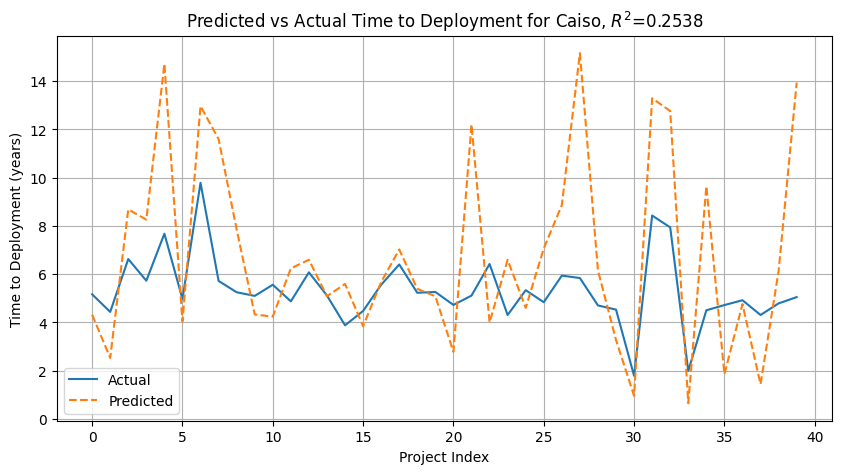

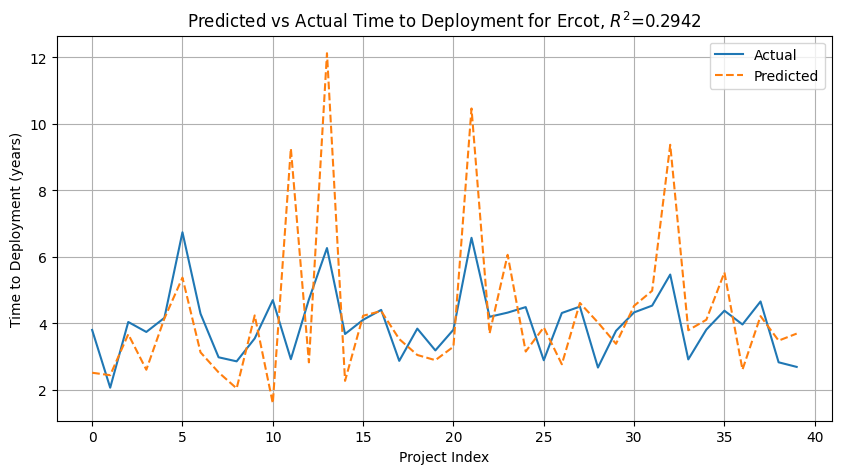

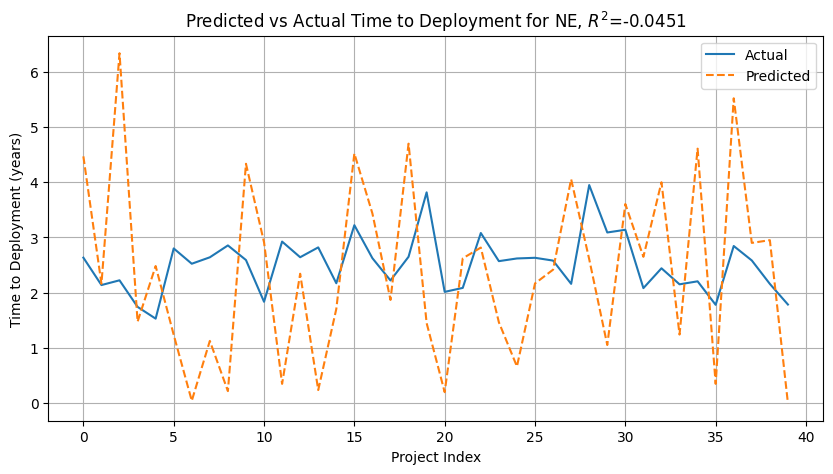

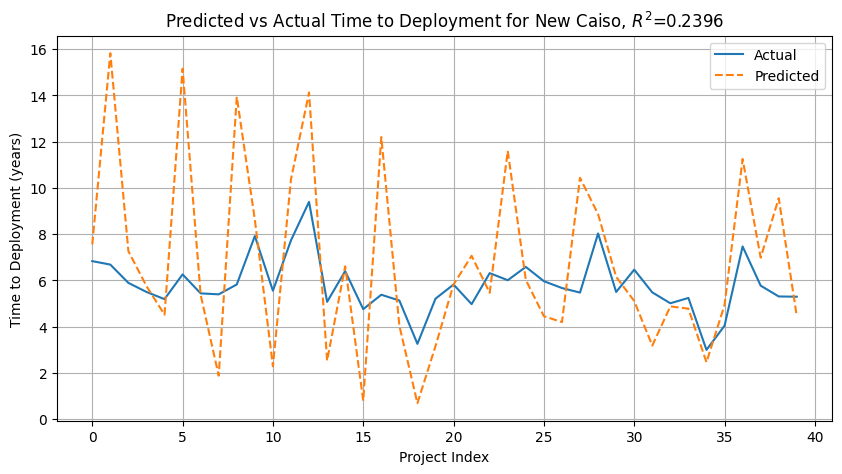

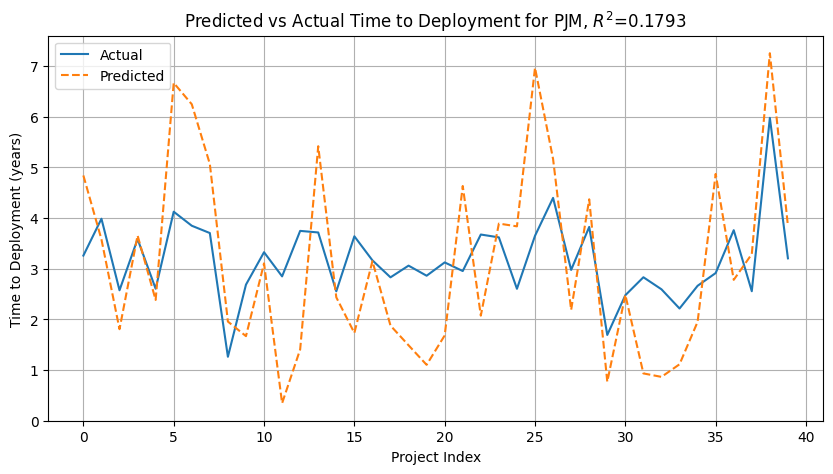

In [102]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import numpy as np

def ridge_cv(iso, function, randomness=False):
    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)

    model = Ridge()
    param_grid = {'alpha': np.logspace(-3, 3, 20)}  # Test 20 values from 0.001 to 1000

    grid_search = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    # print(pd.DataFrame(X_train))
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    r2_seen = r2_score(y_train, y_pred_train)
    r2_unseen = r2_score(y_test, y_pred)

    return r2_seen, r2_unseen, y_test, y_pred
for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
    "New Caiso": new_caiso,
    "PJM": sorted_pjm
}.items():
    predict_and_plot(
        ridge_cv, iso, medium_queue_df,name, randomness=True
    )


### Lasso

Total Completed Projects: 137
Total Withdrawn Projects: 281
R^2 Performance on seen data for Caiso :0.2993 

Total Completed Projects: 191
Total Withdrawn Projects: 45
R^2 Performance on seen data for Ercot :0.2808 

Total Completed Projects: 178
Total Withdrawn Projects: 92
R^2 Performance on seen data for NE :0.1686 

Total Completed Projects: 214
Total Withdrawn Projects: 1633
R^2 Performance on seen data for New Caiso :0.1929 

Total Completed Projects: 1159
Total Withdrawn Projects: 4042
R^2 Performance on seen data for PJM :0.1980 



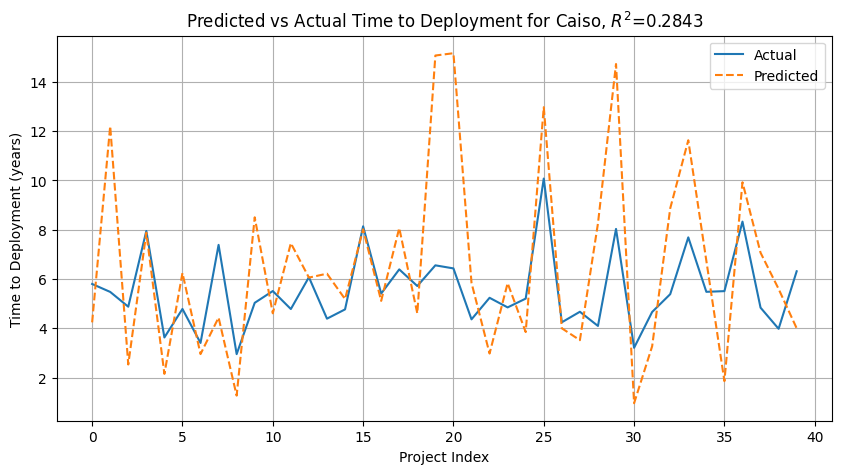

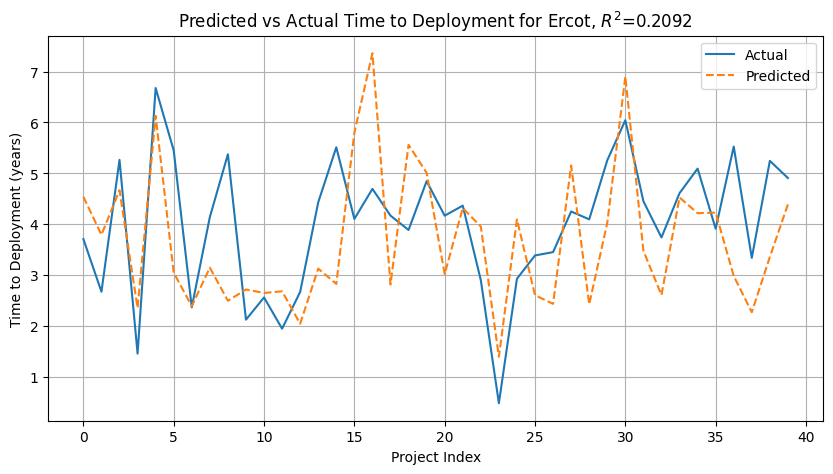

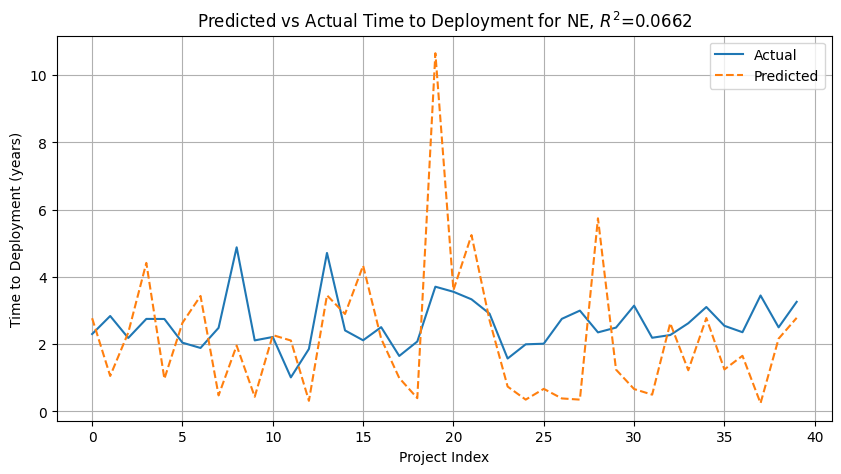

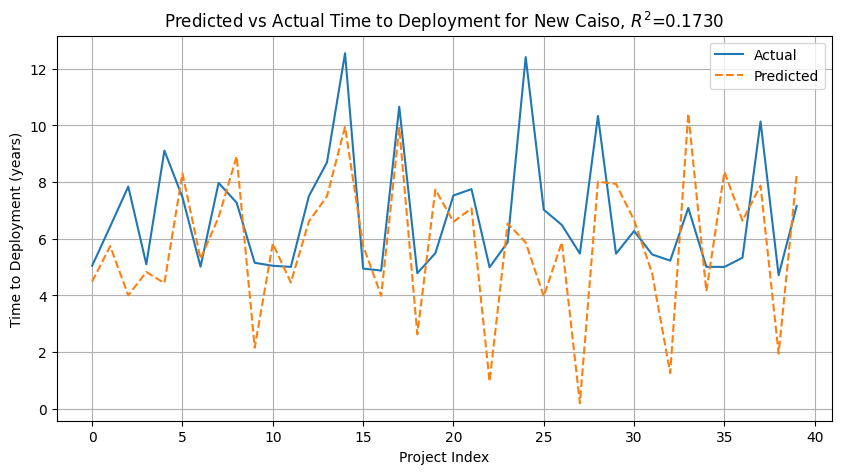

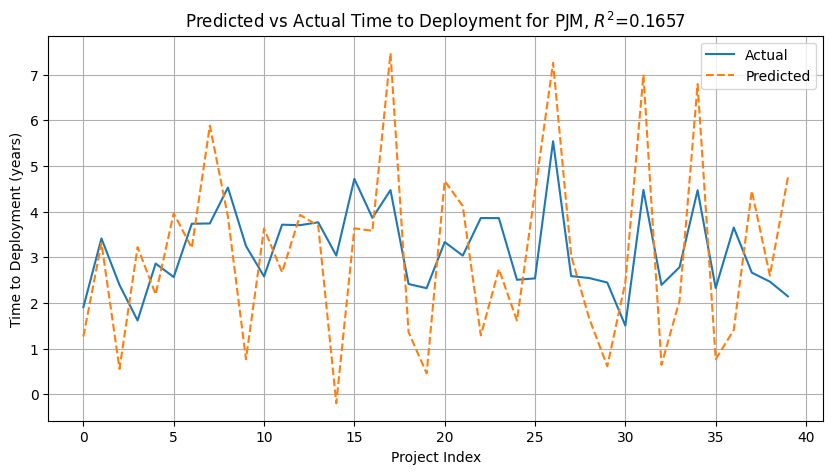

In [ ]:
from sklearn.linear_model import Lasso

def lasso_cv(iso, function, randomness=False):
    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)

    # Define Lasso model and alpha values
    model = Lasso(max_iter=10000)
    param_grid = {'alpha': np.logspace(-4, 1, 20)}  # More sensitive to alpha

    grid_search = GridSearchCV(
        model,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    r2_seen = r2_score(y_train, y_pred_train)
    r2_unseen = r2_score(y_test, y_pred)

    return r2_seen, r2_unseen, y_test, y_pred


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
    "New Caiso": new_caiso,
    "PJM": sorted_pjm
}.items():
    predict_and_plot(
        ridge_cv, iso, queue_by_category_and_capacity,name, randomness=False
    )


### NN

Total Completed Projects: 137
Total Withdrawn Projects: 281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
R^2 Performance on seen data for Caiso :0.2247 

Total Completed Projects: 191
Total Withdrawn Projects: 45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
R^2 Performance on seen data for Ercot :0.1979 

Total Completed Projects: 178
Total Withdrawn Projects: 92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/

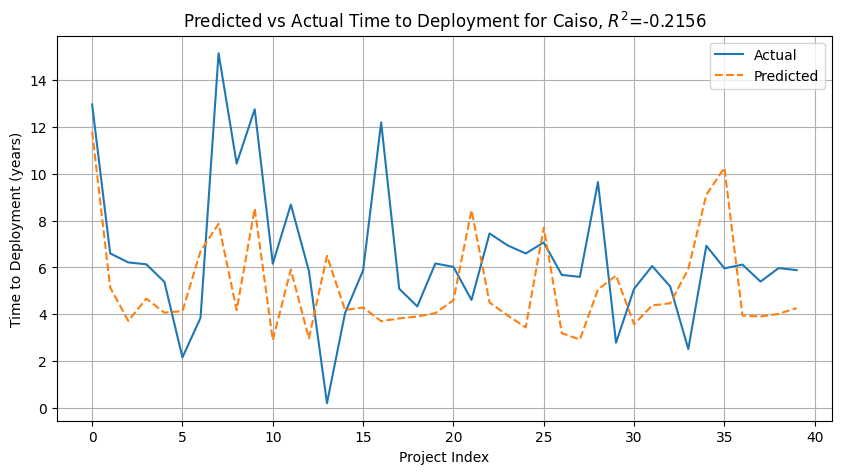

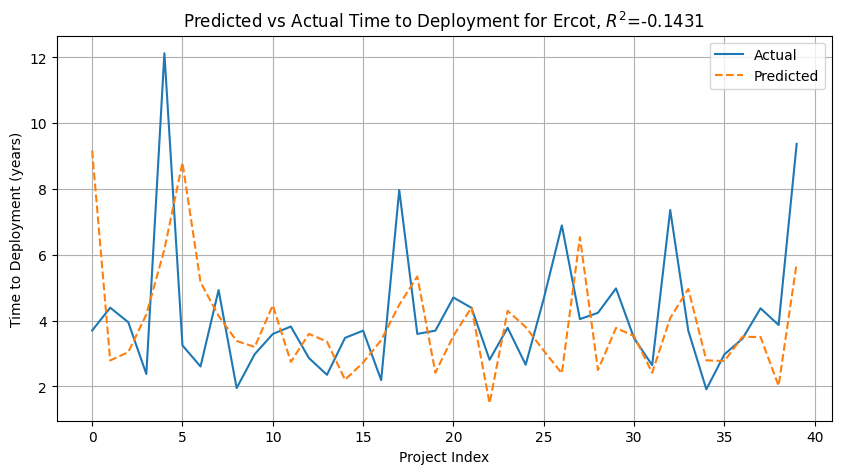

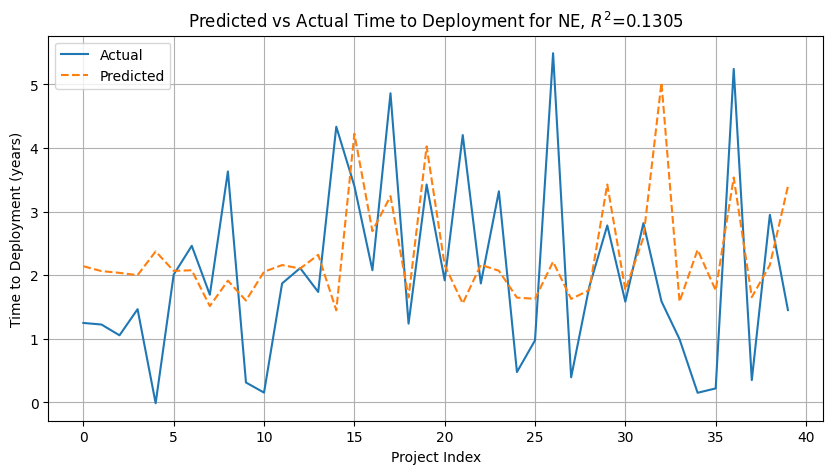

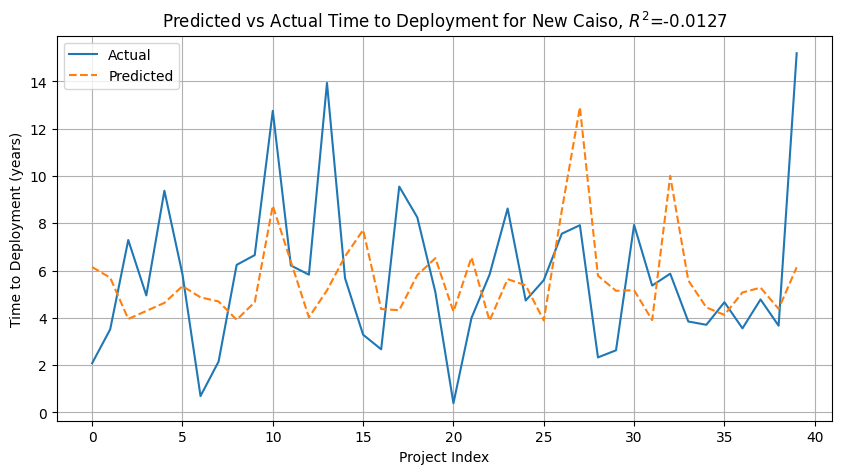

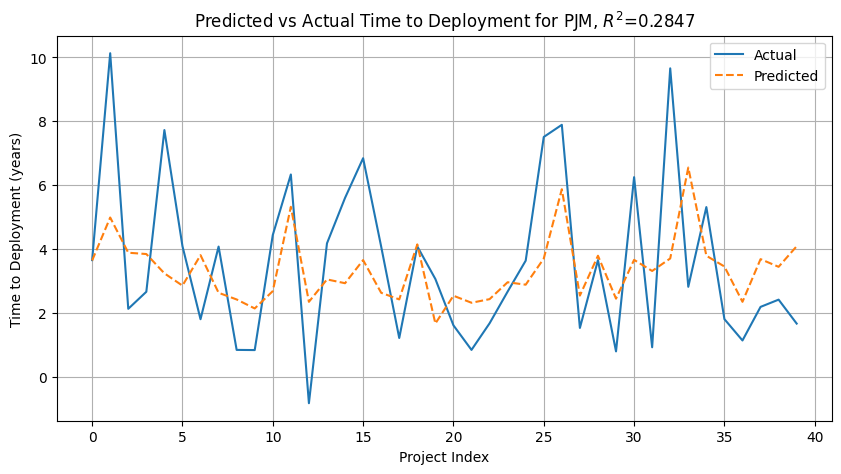

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def neural_net_cv(iso, function, randomness=False, epochs=200, batch_size=32):
    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define model creation function
    def create_model(input_dim):
        model = Sequential()
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))  # Single output for regression
        model.compile(optimizer='adam', loss='mse')
        return model

    # K-Fold Cross Validation on training set
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_r2_scores = []

    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]  # ✅ fixed

        model = create_model(X_tr.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                  epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])

        y_val_pred = model.predict(X_val).flatten()
        val_r2_scores.append(r2_score(y_val, y_val_pred))

    # Retrain on full training data
    final_model = create_model(X_train_scaled.shape[1])
    final_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
                    verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)])

    # Predict on test set
    y_pred = final_model.predict(X_test_scaled).flatten()
    y_pred_train = final_model.predict(X_train_scaled).flatten()

    r2_seen = r2_score(y_train, y_pred_train)
    r2_unseen = r2_score(y_test, y_pred)

    return r2_seen, r2_unseen, y_pred, y_test


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
    "New Caiso": new_caiso,
    "PJM": sorted_pjm
}.items():
    predict_and_plot(
        neural_net_cv, iso, queue_by_category_and_capacity, randomness=False
    )


# Autoregressive model 

Autoregressive (AR) models are a type of time series model that predict future values based on past observations of the same variable.
$$ Y_t = \beta_0 + \beta_1Y_{t-1}+ \epsilon$$
The example above is order 1, an autoregressive model of order n is expressed as the following:
$$ Y_t = \beta_0 + \beta_1Y_{t-1}+ ...+ \beta _nY_{t-n} +\epsilon$$
Autoregressive models require the time series to be stationary, which means there's constant mean and variance over time (which I don't think applies to our case so we would). If the data is not stationary, differencing is required.
There are a couple of easy ways to test whether or not a time series is stationary or not:
 - 1) Augmented Dickey-Fueler 
    - Checks if the time series has a unit root ...
Differencing means subtracting the previous value

useful link: https://developer.ibm.com/tutorials/awb-creating-autoregressive-models-in-python/

In [122]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

def manual_arima_regression(iso, function, arima_order=(20, 1, 0), extra_features=None, randomness=False):
    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)

    model = ARIMA(endog=y_train, exog=X_train if extra_features else None, order=arima_order)
    model_fit = model.fit()

    y_pred_train = model_fit.predict(start=0, end=len(y_train)-1, exog=X_train if extra_features else None)
    y_pred_test = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test if extra_features else None)

    r2_seen = r2_score(y_train, y_pred_train)
    r2_unseen = r2_score(y_test, y_pred_test)

    return r2_seen, r2_unseen, y_pred_test, y_test

for name, iso in {
    "Caiso": sorted_caiso,
    "ERCOT": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    iso = iso.sort_values(by="on_date", ascending = True)
    print(iso[["q_id","q_date","on_date"]])
    # predict_and_plot(
    #     manual_arima_regression, iso, medium_queue_df, name, randomness=False
    # )
    break


               q_id     q_date    on_date
4277             19 2003-06-18 2005-09-30
4009             23 2003-11-24 2005-10-01
3689             12 2002-12-16 2006-03-30
2424             51 2004-12-21 2006-05-30
2582             33 2004-07-12 2006-05-30
...             ...        ...        ...
4515   caiso_c15_96 2023-04-17        NaT
2824  caiso_c15_278 2023-04-17        NaT
3815  caiso_c15_394 2023-04-17        NaT
4509  caiso_c15_367 2023-04-17        NaT
4082  caiso_c15_510 2023-04-17        NaT

[2823 rows x 3 columns]


Using chronological split
R^2 Performance on seen data for Caiso :0.0272 

Using chronological split
R^2 Performance on seen data for Ercot :0.0270 

Using chronological split
R^2 Performance on seen data for NE :0.0112 



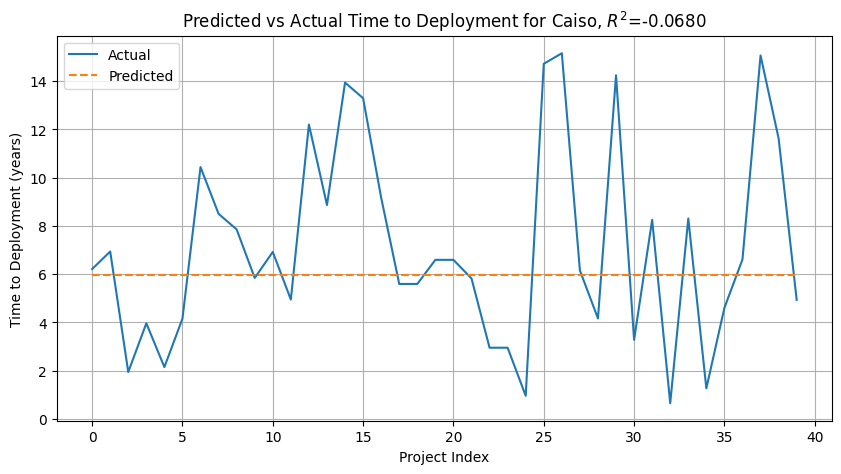

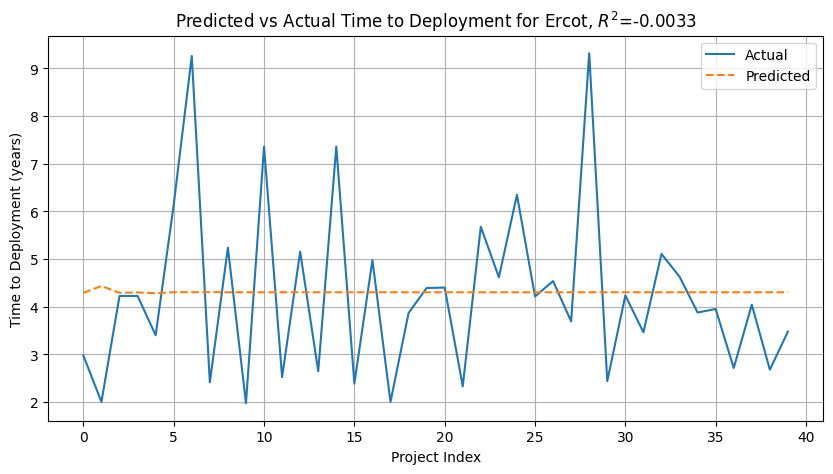

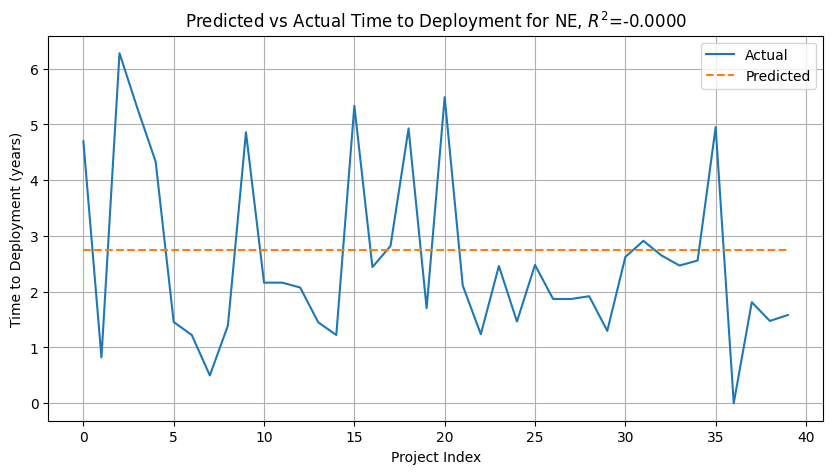

In [123]:
from pmdarima import auto_arima
from sklearn.metrics import r2_score


def arima_regression(iso, function, extra_features=True, randomness=False):
    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)

    if extra_features:
        exog_train = X_train
        exog_test = X_test
    else:
        exog_train = None
        exog_test = None

    model = auto_arima(
        y_train,
        exogenous=exog_train,
        seasonal=False,
        trace=False,
        error_action='ignore',
        suppress_warnings=True
    )

    y_pred_train = model.predict_in_sample(exogenous=exog_train)
    y_pred_test = model.predict(n_periods=len(y_test), exogenous=exog_test)

    r2_seen = r2_score(y_train, y_pred_train)
    r2_unseen = r2_score(y_test, y_pred_test)

    return r2_seen, r2_unseen, y_pred_test, y_test

for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    iso = iso.sort_values(by="on_date", ascending = True)

    predict_and_plot(
        arima_regression, iso, medium_queue_df, name, randomness=False
    )


# Additional thoughts and moving forward

Conclusion: The data is all over the place. Based off the visualizations from a few sections above we found that the interconnection process might not be a strict queue, like we originally thought. A project (project A) that enters after a certain project (project B) has been in the queue for a long time might exist the queue before project B, exists even though project A had entered the queue at a later date. There are a series of factors about why project B might take longer than A besides its capacity or energy source that we can't model or haven't taken into account yet. This would explain why the Autoregression performs so poorly, consecutive projects in the queue have little to no impact on one another. The models perform poorly, though PJM in particular has proven to be somewhat consistent throughout.  
 

For my internship this summer, I am working at Energize Capital, a Venture Capital Firm that specializes in investing in companies in the energy and climate software space. One of the recent companies that they invested in is Nira Energy, which has grid interconnection support tool. The way the tool works is that it monitors each individual substain or bus, keeping track of the current capacity, that way developers can then select buses with more free capacity avoiding wait-times if upgrades would be necessary for a poorly chosen bus. An avenue to consider moving forwad would be a similar apprach that is spatially aware at a more granular scale and considers substation. 

The dataset does include information about the substation, under the column poi_name (Point of Interconnectio Name) and how many kV are being added. Though the amount of historical data available for each bus in the data set could be of concern, I believe that the EIA, might have such information. 

In [ ]:
sorted_caiso

Past Note from Meeting: Take a common enough resource type that is common across all isos and then perform the same regression and see if we can make a prediction.
The data set is all of the US, but for the autoregression it should only be for the respective iso.
Find ways to group resource type

### Survival Analysis (rough and incomplete, disregard for now)

Survival Analysis a method of used to model time-to-event data, in our case it would time until a project is withdrawn or time until completion. 

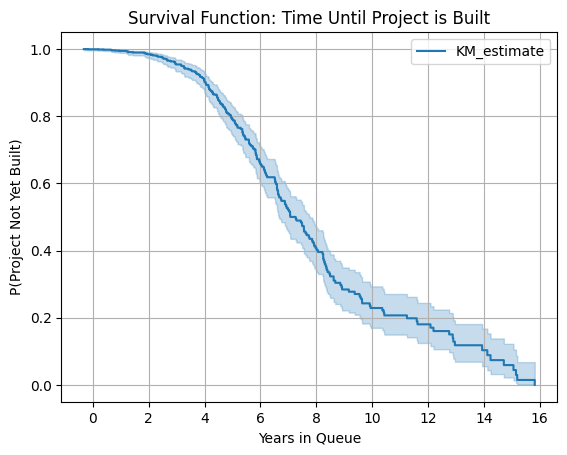

In [ ]:
new_caiso["time_difference"] = calculate_difference(new_caiso, unit="years", withdrawn=True)

new_caiso["event_type"] = new_caiso["q_status"].map({
    "COMPLETED": 1,
    "WITHDRAWN": 2,
    "ACTIVE": 0,
})

new_caiso["event"] = new_caiso["q_status"].apply(lambda x: 1 if x == "COMPLETED" else 0)

# Fit Kaplan-Meier model
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

km_data = new_caiso[["time_difference", "event"]].dropna()

# Fit the model
kmf = KaplanMeierFitter()
kmf.fit(durations=km_data["time_difference"], event_observed=km_data["event"])

# Plot
kmf.plot_survival_function()
plt.title("Survival Function: Time Until Project is Built")
plt.xlabel("Years in Queue")
plt.ylabel("P(Project Not Yet Built)")
plt.grid(True)
plt.show()


This plot gives us the probability that a project has left the queue after x amount of years.

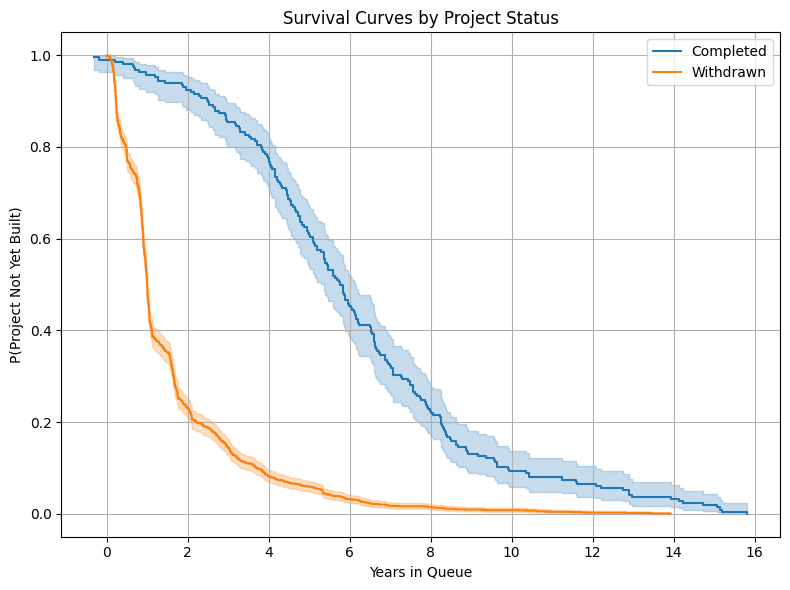

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd

df = new_caiso.copy()
df["time_difference"] = pd.to_numeric(df["time_difference"], errors="coerce")

df = df.dropna(subset=["time_difference", "event_type"])

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

status_labels = {
    1: "Completed",
    2: "Withdrawn",
    0: "Still Active"
}

# Plot each group only if it exists
for status, label in status_labels.items():
    mask = df["event_type"] == status
    group = df[mask]

    if not group.empty:
        durations = group["time_difference"]
        # Event observed is set to 1 for plotting survival curve
        kmf.fit(durations, event_observed=[1]*len(durations), label=label)
        kmf.plot_survival_function(ci_show=True)

plt.title("Survival Curves by Project Status")
plt.xlabel("Years in Queue")
plt.ylabel("P(Project Not Yet Built)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Most projects (80%) are withdrawn within the first 2 years. 

- Goal A: Predict the probability a project is completed within X years
For a new project just entering the queue, what’s the chance it’ll be done within 5 years?

Use Kaplan-Meier or Cox Proportional Hazards for this.

- Goal B: Predict the expected wait time until completion
Estimate how many years the project will likely stay in the queue.

Good for developers planning financing.

- Goal C: Predict the risk of withdrawal vs completion
Use competing risks analysis (e.g. Fine-Gray model).

Useful for understanding project attrition.

- Goal D: Predict completion likelihood based on features
For example:

Project type (solar, wind, battery)

Size (MW)

Location (region)

Date of interconnection request

This needs a Cox model or machine learning survival models.



In [ ]:
print(df.columns)

Index(['q_id', 'q_status', 'q_date', 'ia_date', 'wd_date', 'on_date',
       'type_clean', 'type1', 'type2', 'type3', 'mw1', 'mw2', 'mw3', 'queue',
       'time_difference', 'event_type', 'event'],
      dtype='object')


In [ ]:
from lifelines import CoxPHFitter

# Select features + target
df_model = df[["time_difference", "event_type", "mw1", "type_clean"]].copy()

# Encode categorical variables
df_model = pd.get_dummies(df_model, columns=["type_clean"], drop_first=True)

# Filter only completed and withdrawn (drop active)
df_model = df_model[df_model["event_type"] != 0]

# Rename for lifelines
df_model = df_model.rename(columns={"time_difference": "duration", "event_type": "event"})

# Event: treat 1 = completed as event, 2 = withdrawn as censored (or vice versa)
df_model["event"] = df_model["event"] == 1  # Completed = 1, Withdrawn = 0

# Fit model
cph = CoxPHFitter()
cph.fit(df_model, duration_col="duration", event_col="event")
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 1847 total observations, 1633 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1847
number of events observed = 214
   partial log-likelihood = -1031.24
         time fit was run = 2025-06-01 22:48:02 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
mw1                             -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
type_clean_Combined Cycle       -3.11      0.04      1.07           -5.20           -1.02                0.01                0.36
type_clean_Combustion Turbine   -2.72      0.07      1.08           -4.83           -0.60                0.01                0.55
type_clean_Gas Turbine          -3.24      0.04      1.10           -5.40           -1.08                0.00                0.34
type_clean_Hydro                -0.96      0.38      1.42           -3.75            1.83                0.02                6.23
type_clean_Other                -5.11      0.01      1.46           -7.97           -2.25                0.00                0.11
type_clean_Photovoltaic         -3.63      0.03      1.04           -5.66           -1.59                0.00                0.20
type_clean_Reciprocating Engine -3.75      0.02      1.44           -6.57           -0.94                0.00                0.39
type_clean_Solar Thermal        -1.23      0.29      1.43           -4.04            1.58                0.02                4.87
type_clean_Steam Turbine        -3.55      0.03      1.06           -5.64           -1.47                0.00                0.23
type_clean_Storage              -3.55      0.03      1.05           -5.61           -1.49                0.00                0.22
type_clean_Wind Turbine         -3.85      0.02      1.06           -5.93           -1.78                0.00                0.17

                                 cmp to     z      p  -log2(p)
covariate                                                     
mw1                                0.00 -5.09 <0.005     21.41
type_clean_Combined Cycle          0.00 -2.92 <0.005      8.15
type_clean_Combustion Turbine      0.00 -2.52   0.01      6.40
type_clean_Gas Turbine             0.00 -2.93 <0.005      8.23
type_clean_Hydro                   0.00 -0.67   0.50      1.00
type_clean_Other                   0.00 -3.50 <0.005     11.07
type_clean_Photovoltaic            0.00 -3.50 <0.005     11.04
type_clean_Reciprocating Engine    0.00 -2.61   0.01      6.79
type_clean_Solar Thermal           0.00 -0.86   0.39      1.35
type_clean_Steam Turbine           0.00 -3.35 <0.005     10.26
type_clean_Storage                 0.00 -3.38 <0.005     10.43
type_clean_Wind Turbine            0.00 -3.64 <0.005     11.82
---
Concordance = 0.72
Partial AIC = 2086.48
log-likelihood ratio test = 57.40 on 12 df
-log2(p) of ll-ratio test = 23.84

In [ ]:
queue_state = queue_by_category_and_capacity(new_caiso)
queue_state

q_id   q_status              q_date ia_date wd_date             on_date  \
0      1A  COMPLETED 1999-11-01 08:00:00     NaT     NaT 2009-10-02 07:00:00   
1       2  COMPLETED 2000-02-03 08:00:00     NaT     NaT 2009-01-06 08:00:00   
2       3  COMPLETED 2000-06-14 07:00:00     NaT     NaT 2013-06-01 07:00:00   
3       4  COMPLETED 2000-08-08 07:00:00     NaT     NaT 2005-10-14 07:00:00   
229     5  WITHDRAWN 2000-08-09 07:00:00     NaT     NaT                 NaT   
...   ...        ...                 ...     ...     ...                 ...   
2286  nan        NaN                 NaT     NaT     NaT                 NaT   
2287  nan        NaN                 NaT     NaT     NaT                 NaT   
2288  nan        NaN                 NaT     NaT     NaT                 NaT   
2289  nan        NaN                 NaT     NaT     NaT                 NaT   
2290  nan        NaN                 NaT     NaT     NaT                 NaT   

          type_clean  type1  type2  type3  ...  queue  time_difference  \
0     Combined Cycle      2      0      0  ...    1.0         9.916496   
1     Combined Cycle      2      0      0  ...    2.0         8.925394   
2        Gas Turbine      2      3      0  ...    3.0        12.963723   
3     Combined Cycle      2      0      0  ...    4.0         5.182752   
229   Combined Cycle      2      0      0  ...    5.0              NaN   
...              ...    ...    ...    ...  ...    ...              ...   
2286             NaN      0      0      0  ...  522.0              NaN   
2287             NaN      0      0      0  ...  523.0              NaN   
2288             NaN      0      0      0  ...  524.0              NaN   
2289             NaN      0      0      0  ...  525.0              NaN   
2290             NaN      0      0      0  ...  526.0              NaN   

      event_type  event  n_renewable  n_non_renewable  n_storage  \
0            1.0      1          0.0              1.0        0.0   
1            1.0      1          0.0              2.0        0.0   
2            1.0      1          0.0              3.0        1.0   
3            1.0      1          0.0              4.0        1.0   
229          2.0      0          0.0              5.0        1.0   
...          ...    ...          ...              ...        ...   
2286         NaN      0        258.0             41.0      440.0   
2287         NaN      0        258.0             41.0      440.0   
2288         NaN      0        258.0             41.0      440.0   
2289         NaN      0        258.0             41.0      440.0   
2290         NaN      0        258.0             41.0      440.0   

      mw_renewable  mw_non_renewable     mw_storage  
0         0.000000        550.000000       0.000000  
1         0.000000       1140.000000       0.000000  
2         0.000000       1990.000000      16.000000  
3         0.000000       2511.000000      16.000000  
229       0.000000       3411.000000      16.000000  
...            ...               ...            ...  
2286  73952.080145      11833.604999  112488.810373  
2287  73952.080145      11833.604999  112488.810373  
2288  73952.080145      11833.604999  112488.810373  
2289  73952.080145      11833.604999  112488.810373  
2290  73952.080145      11833.604999  112488.810373  

[2291 rows x 23 columns]

In [ ]:
import pandas as pd
from datetime import datetime

# Replace with your actual DataFrame name
df["start_date"] = pd.to_datetime(df["start_date"])
df["exit_date"] = pd.to_datetime(df["exit_date"])

# Fill in exit date as today for active projects
today = pd.to_datetime("today")
df["exit_filled"] = df["exit_date"].fillna(today)

# Calculate duration in years (or days, as you prefer)
df["duration"] = (df["exit_filled"] - df["start_date"]).dt.total_seconds() / (365.25 * 24 * 3600)

# Define event: 1 = completed, 0 = censored (withdrawn or active)
df["event"] = df["event_type"].apply(lambda x: 1 if x == 1 else 0)

# Encode fuel_type (binary)
df["fuel_renewable"] = df["fuel_type"].apply(lambda x: 1 if x == "renewable" else 0)

# Drop unnecessary columns
df_model = df[["duration", "event", "fuel_renewable", "capacity_mw", "queue_state_at_entry"]].dropna()
